# Replicating 5. "Factor Momentum  and the Momentum Factor"

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import functools
from scipy import stats
import statsmodels.formula.api as smf

**Define utility functions**

In [2]:
# Filter equally weighted or value weighted factors from data columns
def choose_w(data, w):
    return data.loc[:, [column for column in data.columns if w in column]]

In [3]:
# Taken from lectures. Find last day of corresponding month given date.
def end_of_month(x):
    if not isinstance(x, str):
        return x
    return pd.to_datetime(x) - pd.tseries.offsets.MonthBegin(1)

In [4]:
# Find similarity between normal distribution and given distribution in each column of data.
def t_test(xs):
    rng = np.random.default_rng()
    tvalues = xs.agg(lambda g: 
                     stats.ttest_ind(g.values, 
                                     stats.norm.rvs(loc=g.mean(), scale=g.std(), size=1000, random_state=rng)
                                    ).statistic
                    )
    return tvalues

In [5]:
# aggregate nearby rows, each row is a principal component.
def PC_group(df, bins = 5):
    n = len(df.index)
    df['group'] = pd.cut([i for i in range(n)], 
                        bins, 
                        labels=["%s~%s" % (df.index[i * n//bins], df.index[(i+1) * n//bins - 1].split("_")[-1]) for i in range(bins)])
    return df.groupby('group', group_keys=False).mean()

In [6]:
# Compute profit/loss of next month based on trading strategy.
def PC_trading(df, cost=0.0):
    df_factors = choose_w(df, '_lag')
    df_trade = df.drop(df_factors.columns, axis=1)
    
    # step 1: Compute eigenvectors using daily returns on all factors.
    pca = PCA(n_components=df_factors.shape[1])
    pca.fit(df_factors.values)
    pc_factors = pca.components_
    eigenvalues = pca.explained_variance_
    
    # Sort principal components in descending order of eigenvalues.
    pc_factors = pd.DataFrame(pc_factors, 
                              columns=df_factors.columns, 
                              index=['Component_%s' % i 
                                     for i in range(pc_factors.shape[1])]
                             ).iloc[:, 
                                    pd.Series(eigenvalues, 
                                              index=range(eigenvalues.shape[0])).sort_values().index.to_list()
                                   ]
    
    # Sort factor return accordingly.
    df_factors = df_factors.loc[:, pc_factors.columns]
    df_trade = df_trade.loc[:, [column[:-4] for column in pc_factors.columns]]
    
    # step 2: Compute monthly returns for the PC factors up to month t
    pc_returns = pc_factors.dot(df_factors.values.T) # column: date, index: pc components.
    pc_returns.columns = df_factors.index
    
    # step 3: Rescale PC factors to mean = 0 and variance = factors variance.
    factors_var = df_factors.std(axis=1).mean()
    pc_returns_norm = pc_returns.transform(lambda g: g.apply(lambda x: (x - g.mean()) * factors_var / g.std()), axis=1)
    
    # step 4: take long positions in the PC factors with positive average returns from month t - 11 to t and short positions in factors with negative average returns.
    num_LS = pc_returns_norm.shape[0] // 10
    pc_performance = pc_returns_norm.loc[:, 
                                         pc_returns_norm.columns > (pc_returns_norm.columns.max() - pd.DateOffset(years = 1))
                                        ].sum(axis=1).sort_values()
    
    pc_Long = pc_performance.index[-num_LS:]
    pc_Short = pc_performance.index[:num_LS]
    
    res = {}
    res['return'] = (df_trade.index[-1] + pd.DateOffset(months = 1), 
                     (pc_factors.loc[pc_Long, :].dot(df_trade.values.T).values - pc_factors.loc[pc_Short, :].dot(df_trade.values.T).values).sum().sum() - cost # column: date, index: pc components.
                    )
    # Find performance of each group of principal components, used to make table 3.
    res['PC_ranks'] = PC_group(pc_returns)
    
    
    return res

In [7]:
# merge dataframes accroding to index
def merge_many_dfs(dfs):
    res_df = dfs[0]
    for df in dfs[1:]:
        res_df = res_df.merge(df, left_index=True, right_index=True)
    return res_df

In [8]:
# Add title to dataframe exhibit
def df_add_title(df, title):
    if df.shape[0] < 50:
        return df.style.set_caption(title).set_table_styles([{'selector': 'caption', 'props': 'caption-side: top; font-size: 2em;'}], overwrite=False)
    else:
        idx = df.index[10:]
        return df.style.hide(subset=idx).set_caption(title).set_table_styles([{'selector': 'caption', 'props': 'caption-side: top; font-size: 2em;'}], overwrite=False)

**Read and process data**

In [9]:
def remove_mom_factor(data):
    return data.loc[:, [col for col in data.columns if 'mom' not in col]]

In [10]:
def create_ew_data(data):
    return data.merge(
        data.loc[:, [col for col in data.columns if 'q_' in col]].multiply(abs(data.loc[:, 'size']), axis=0),
        left_index=True, 
        right_index=True, 
        suffixes=('_ew', '_vw'))

In [11]:
def index_to_datetime(data):
    data.index = [end_of_month(idx) for idx in data.index]
    return data

In [12]:
# Read data
data_china = pd.read_csv('./data/China/FactorReturnsChinamonthly.csv', index_col=0).set_index('Date')
data_hk = pd.read_csv('./data/HK/FactorReturnsHKmonthly.csv', index_col=0).set_index('Date')
data_us = pd.read_csv('./data/US/FactorReturnsUSmonthly.csv', index_col=0).set_index('Date')

data_china.columns.name = 'predictor_file'
data_hk.columns.name = 'predictor_file'
data_us.columns.name = 'predictor_file'

data = dict(zip(['china', 'hk', 'us'], [data_china, data_hk, data_us]))

In [13]:
# Remove momentum factors, so that we will not study momentum of momentum, which is not the focus of paper to be replicated.
data = {region: remove_mom_factor(data_) for region, data_ in data.items()}

In [14]:
# Find common factors among 3 regions that have few missing values.
threshold = 0.1
common_factors = []
for region, data_ in data.items():
    common_factors += list(data_.loc[:, (data_.isna().sum() < (threshold * data_.shape[0])).values].columns)
common_factors = list(set(common_factors))

# In addition, fill in missing values with linear interpolation.
data = {region: data_.loc[:, common_factors].interpolate().fillna(0) for region, data_ in data.items()}

In [15]:
# Given equally-weighted data and size, create value-weighted data.
data = {region: create_ew_data(data_) for region, data_ in data.items()}

# Convert index of data to pandas datetime
data = {region: index_to_datetime(data_) for region, data_ in data.items()}
min_idx = max([min(data_.index) for data_ in data.values()])

# Truncate old data such that backtest periods for 3 financial markets are the same.
data = {region: data_.loc[data_.index > min_idx] for region, data_ in data.items()}

In [16]:
# Remove columns that are not factors.
data = {region: data_.loc[:, [col for col in data_.columns if 'q_' in col]] for region, data_ in data.items()}

**Take a look on processed data.**

In [17]:
df_add_title(data['china'].head(), 'A Glance on China Data')

predictor_file,q_payout_ew,q_compositeDebtIssuance_ew,q_ep_ew,q_rndPerAsset_ew,q_rdBiases_ew,q_abnormalProdCost_ew,q_lossReversal_ew,q_scaledEarningsGrowth_ew,q_revSurprise_ew,q_ltInvDiff_ew,q_roa_ew,q_nfaDiff_ew,q_nonCurrentOpAssets_ew,q_debtCoverage_ew,q_roce_ew,q_nonCashWCDiff_ew,q_revMinusSgaDiff_ew,q_abnormalCfo_ew,q_abAccrual_ew,q_mScoreRankNew_ew,q_nonCurrOADiff_ew,q_operatingProfitability_ew,q_invToCapital_ew,q_abnormalCapex_ew,q_goodwillGrowth_ew,q_grossMarginDiff_ew,q_revGrowth_ew,q_herfindahl_ew,q_payoutCommon_ew,q_scaledEbitGrowth_ew,q_accrual_ew,q_debtDiff_ew,q_beme_ew,q_roaDiff_ew,q_overProduction_ew,q_ArAccrual_ew,q_noa_ew,q_opLeverage_ew,q_oScoreAlt_ew,q_earningsIncLength_ew,q_invAccrual_ew,q_earningsConsistency_ew,q_colDiff_ew,q_marginDiff_ew,q_roNoa_ew,q_invDiff_ew,q_scaledCfoGrowth_ew,q_enterpriseMultipleInv_ew,q_enterpriseBeme_ew,q_deferredRevDiff_ew,q_yield_ew,q_cashDistEquity_ew,q_cfoVol_ew,q_productivity_ew,q_taxIncomeRatio_ew,q_liquidity_ew,q_zScoreAlt_ew,q_cashRatio_ew,q_ltNoaGrowth_ew,q_marketLeverage_ew,q_leverageComponentBeme_ew,q_eScore_ew,q_stInvDiff_ew,q_assetDiff_ew,q_rdToRev_ew,q_rdAvg_ew,q_ebitMargin_ew,q_cashHand_ew,q_accrualCfo_ew,q_coaDiff_ew,q_debtBook_ew,q_revMe_ew,q_abnormalInvScaled_ew,q_totalAccrualEarnings_ew,q_rdAdjustedROE_ew,q_earningsDistEquity_ew,q_goodwillToAssets_ew,q_accrualCfoEarnings_ew,q_noaTurnover_ew,q_ncoaDiff_ew,q_grossProfitability_ew,q_earningsSurprise_ew,q_cash2Price_ew,q_flDiff_ew,q_leverage_ew,q_netExternalFin_ew,q_invToAssets_ew,q_hiringRate_ew,q_totalAccrual_ew,q_convertibleDebt_ew,q_taxExpSurprise_ew,q_earningsVol_ew,q_cfoYield_ew,q_goodwillImpairment_ew,q_fScore_ew,q_repurchaseBinary_ew,q_abnormalInv_ew,q_expectedGrowth_ew,q_ncolDiff_ew,q_noaTurnoverDiff_ew,q_payout_vw,q_compositeDebtIssuance_vw,q_ep_vw,q_rndPerAsset_vw,q_rdBiases_vw,q_abnormalProdCost_vw,q_lossReversal_vw,q_scaledEarningsGrowth_vw,q_revSurprise_vw,q_ltInvDiff_vw,q_roa_vw,q_nfaDiff_vw,q_nonCurrentOpAssets_vw,q_debtCoverage_vw,q_roce_vw,q_nonCashWCDiff_vw,q_revMinusSgaDiff_vw,q_abnormalCfo_vw,q_abAccrual_vw,q_mScoreRankNew_vw,q_nonCurrOADiff_vw,q_operatingProfitability_vw,q_invToCapital_vw,q_abnormalCapex_vw,q_goodwillGrowth_vw,q_grossMarginDiff_vw,q_revGrowth_vw,q_herfindahl_vw,q_payoutCommon_vw,q_scaledEbitGrowth_vw,q_accrual_vw,q_debtDiff_vw,q_beme_vw,q_roaDiff_vw,q_overProduction_vw,q_ArAccrual_vw,q_noa_vw,q_opLeverage_vw,q_oScoreAlt_vw,q_earningsIncLength_vw,q_invAccrual_vw,q_earningsConsistency_vw,q_colDiff_vw,q_marginDiff_vw,q_roNoa_vw,q_invDiff_vw,q_scaledCfoGrowth_vw,q_enterpriseMultipleInv_vw,q_enterpriseBeme_vw,q_deferredRevDiff_vw,q_yield_vw,q_cashDistEquity_vw,q_cfoVol_vw,q_productivity_vw,q_taxIncomeRatio_vw,q_liquidity_vw,q_zScoreAlt_vw,q_cashRatio_vw,q_ltNoaGrowth_vw,q_marketLeverage_vw,q_leverageComponentBeme_vw,q_eScore_vw,q_stInvDiff_vw,q_assetDiff_vw,q_rdToRev_vw,q_rdAvg_vw,q_ebitMargin_vw,q_cashHand_vw,q_accrualCfo_vw,q_coaDiff_vw,q_debtBook_vw,q_revMe_vw,q_abnormalInvScaled_vw,q_totalAccrualEarnings_vw,q_rdAdjustedROE_vw,q_earningsDistEquity_vw,q_goodwillToAssets_vw,q_accrualCfoEarnings_vw,q_noaTurnover_vw,q_ncoaDiff_vw,q_grossProfitability_vw,q_earningsSurprise_vw,q_cash2Price_vw,q_flDiff_vw,q_leverage_vw,q_netExternalFin_vw,q_invToAssets_vw,q_hiringRate_vw,q_totalAccrual_vw,q_convertibleDebt_vw,q_taxExpSurprise_vw,q_earningsVol_vw,q_cfoYield_vw,q_goodwillImpairment_vw,q_fScore_vw,q_repurchaseBinary_vw,q_abnormalInv_vw,q_expectedGrowth_vw,q_ncolDiff_vw,q_noaTurnoverDiff_vw
2000-08-01 00:00:00,-0.025194,0.005936,-0.018174,0.000000,0.000000,-0.002726,0.000000,0.007123,0.003197,-0.000393,-0.009526,-0.009167,0.001205,-0.026461,-0.005498,0.002669,0.005375,-0.014630,-0.019277,-0.017337,-0.007051,-0.024993,-0.005497,-0.022144,0.000000,0.009817,0.003070,-0.021050,-0.025156,0.003283,0.000502,0.009343,-0.016756,0.004134,-0.008978,0.011089,0.003062,0.008850,0.018184,0,-0.013280,-0.003255,0.001896,-0.005247,-0.001609,0.000700,-0.000283,-0.022860,-0.009101,0.000000,-0.025156,-0.023380,

In [18]:
df_add_title(data['hk'].head(), 'A Glance on HK Data')

predictor_file,q_payout_ew,q_compositeDebtIssuance_ew,q_ep_ew,q_rndPerAsset_ew,q_rdBiases_ew,q_abnormalProdCost_ew,q_lossReversal_ew,q_scaledEarningsGrowth_ew,q_revSurprise_ew,q_ltInvDiff_ew,q_roa_ew,q_nfaDiff_ew,q_nonCurrentOpAssets_ew,q_debtCoverage_ew,q_roce_ew,q_nonCashWCDiff_ew,q_revMinusSgaDiff_ew,q_abnormalCfo_ew,q_abAccrual_ew,q_mScoreRankNew_ew,q_nonCurrOADiff_ew,q_operatingProfitability_ew,q_invToCapital_ew,q_abnormalCapex_ew,q_goodwillGrowth_ew,q_grossMarginDiff_ew,q_revGrowth_ew,q_herfindahl_ew,q_payoutCommon_ew,q_scaledEbitGrowth_ew,q_accrual_ew,q_debtDiff_ew,q_beme_ew,q_roaDiff_ew,q_overProduction_ew,q_ArAccrual_ew,q_noa_ew,q_opLeverage_ew,q_oScoreAlt_ew,q_earningsIncLength_ew,q_invAccrual_ew,q_earningsConsistency_ew,q_colDiff_ew,q_marginDiff_ew,q_roNoa_ew,q_invDiff_ew,q_scaledCfoGrowth_ew,q_enterpriseMultipleInv_ew,q_enterpriseBeme_ew,q_deferredRevDiff_ew,q_yield_ew,q_cashDistEquity_ew,q_cfoVol_ew,q_productivity_ew,q_taxIncomeRatio_ew,q_liquidity_ew,q_zScoreAlt_ew,q_cashRatio_ew,q_ltNoaGrowth_ew,q_marketLeverage_ew,q_leverageComponentBeme_ew,q_eScore_ew,q_stInvDiff_ew,q_assetDiff_ew,q_rdToRev_ew,q_rdAvg_ew,q_ebitMargin_ew,q_cashHand_ew,q_accrualCfo_ew,q_coaDiff_ew,q_debtBook_ew,q_revMe_ew,q_abnormalInvScaled_ew,q_totalAccrualEarnings_ew,q_rdAdjustedROE_ew,q_earningsDistEquity_ew,q_goodwillToAssets_ew,q_accrualCfoEarnings_ew,q_noaTurnover_ew,q_ncoaDiff_ew,q_grossProfitability_ew,q_earningsSurprise_ew,q_cash2Price_ew,q_flDiff_ew,q_leverage_ew,q_netExternalFin_ew,q_invToAssets_ew,q_hiringRate_ew,q_totalAccrual_ew,q_convertibleDebt_ew,q_taxExpSurprise_ew,q_earningsVol_ew,q_cfoYield_ew,q_goodwillImpairment_ew,q_fScore_ew,q_repurchaseBinary_ew,q_abnormalInv_ew,q_expectedGrowth_ew,q_ncolDiff_ew,q_noaTurnoverDiff_ew,q_payout_vw,q_compositeDebtIssuance_vw,q_ep_vw,q_rndPerAsset_vw,q_rdBiases_vw,q_abnormalProdCost_vw,q_lossReversal_vw,q_scaledEarningsGrowth_vw,q_revSurprise_vw,q_ltInvDiff_vw,q_roa_vw,q_nfaDiff_vw,q_nonCurrentOpAssets_vw,q_debtCoverage_vw,q_roce_vw,q_nonCashWCDiff_vw,q_revMinusSgaDiff_vw,q_abnormalCfo_vw,q_abAccrual_vw,q_mScoreRankNew_vw,q_nonCurrOADiff_vw,q_operatingProfitability_vw,q_invToCapital_vw,q_abnormalCapex_vw,q_goodwillGrowth_vw,q_grossMarginDiff_vw,q_revGrowth_vw,q_herfindahl_vw,q_payoutCommon_vw,q_scaledEbitGrowth_vw,q_accrual_vw,q_debtDiff_vw,q_beme_vw,q_roaDiff_vw,q_overProduction_vw,q_ArAccrual_vw,q_noa_vw,q_opLeverage_vw,q_oScoreAlt_vw,q_earningsIncLength_vw,q_invAccrual_vw,q_earningsConsistency_vw,q_colDiff_vw,q_marginDiff_vw,q_roNoa_vw,q_invDiff_vw,q_scaledCfoGrowth_vw,q_enterpriseMultipleInv_vw,q_enterpriseBeme_vw,q_deferredRevDiff_vw,q_yield_vw,q_cashDistEquity_vw,q_cfoVol_vw,q_productivity_vw,q_taxIncomeRatio_vw,q_liquidity_vw,q_zScoreAlt_vw,q_cashRatio_vw,q_ltNoaGrowth_vw,q_marketLeverage_vw,q_leverageComponentBeme_vw,q_eScore_vw,q_stInvDiff_vw,q_assetDiff_vw,q_rdToRev_vw,q_rdAvg_vw,q_ebitMargin_vw,q_cashHand_vw,q_accrualCfo_vw,q_coaDiff_vw,q_debtBook_vw,q_revMe_vw,q_abnormalInvScaled_vw,q_totalAccrualEarnings_vw,q_rdAdjustedROE_vw,q_earningsDistEquity_vw,q_goodwillToAssets_vw,q_accrualCfoEarnings_vw,q_noaTurnover_vw,q_ncoaDiff_vw,q_grossProfitability_vw,q_earningsSurprise_vw,q_cash2Price_vw,q_flDiff_vw,q_leverage_vw,q_netExternalFin_vw,q_invToAssets_vw,q_hiringRate_vw,q_totalAccrual_vw,q_convertibleDebt_vw,q_taxExpSurprise_vw,q_earningsVol_vw,q_cfoYield_vw,q_goodwillImpairment_vw,q_fScore_vw,q_repurchaseBinary_vw,q_abnormalInv_vw,q_expectedGrowth_vw,q_ncolDiff_vw,q_noaTurnoverDiff_vw
2000-08-01 00:00:00,0.031676,0.032489,0.205080,-0.075656,0.141938,-0.055260,0.000000,-0.084407,-0.060875,-0.163670,-0.060402,-0.012059,0.070389,-0.064924,-0.100906,0.141598,-0.058472,0.074535,0.216487,0.121446,-0.079178,-0.038342,-0.194726,-0.074091,0.000000,-0.170158,0.013859,-0.086235,0.139824,-0.119142,0.128677,-0.147695,0.207902,-0.097381,0.087278,0.048785,0.131211,-0.114400,-0.039576,0,0.014070,-0.204887,-0.151178,-0.042842,-0.195048,-0.098220,0.046997,0.144593,0.206892,0.181101,0.138194,-0.030677,0

In [19]:
df_add_title(data['us'].head(), 'A Glance on US Data')

predictor_file,q_payout_ew,q_compositeDebtIssuance_ew,q_ep_ew,q_rndPerAsset_ew,q_rdBiases_ew,q_abnormalProdCost_ew,q_lossReversal_ew,q_scaledEarningsGrowth_ew,q_revSurprise_ew,q_ltInvDiff_ew,q_roa_ew,q_nfaDiff_ew,q_nonCurrentOpAssets_ew,q_debtCoverage_ew,q_roce_ew,q_nonCashWCDiff_ew,q_revMinusSgaDiff_ew,q_abnormalCfo_ew,q_abAccrual_ew,q_mScoreRankNew_ew,q_nonCurrOADiff_ew,q_operatingProfitability_ew,q_invToCapital_ew,q_abnormalCapex_ew,q_goodwillGrowth_ew,q_grossMarginDiff_ew,q_revGrowth_ew,q_herfindahl_ew,q_payoutCommon_ew,q_scaledEbitGrowth_ew,q_accrual_ew,q_debtDiff_ew,q_beme_ew,q_roaDiff_ew,q_overProduction_ew,q_ArAccrual_ew,q_noa_ew,q_opLeverage_ew,q_oScoreAlt_ew,q_earningsIncLength_ew,q_invAccrual_ew,q_earningsConsistency_ew,q_colDiff_ew,q_marginDiff_ew,q_roNoa_ew,q_invDiff_ew,q_scaledCfoGrowth_ew,q_enterpriseMultipleInv_ew,q_enterpriseBeme_ew,q_deferredRevDiff_ew,q_yield_ew,q_cashDistEquity_ew,q_cfoVol_ew,q_productivity_ew,q_taxIncomeRatio_ew,q_liquidity_ew,q_zScoreAlt_ew,q_cashRatio_ew,q_ltNoaGrowth_ew,q_marketLeverage_ew,q_leverageComponentBeme_ew,q_eScore_ew,q_stInvDiff_ew,q_assetDiff_ew,q_rdToRev_ew,q_rdAvg_ew,q_ebitMargin_ew,q_cashHand_ew,q_accrualCfo_ew,q_coaDiff_ew,q_debtBook_ew,q_revMe_ew,q_abnormalInvScaled_ew,q_totalAccrualEarnings_ew,q_rdAdjustedROE_ew,q_earningsDistEquity_ew,q_goodwillToAssets_ew,q_accrualCfoEarnings_ew,q_noaTurnover_ew,q_ncoaDiff_ew,q_grossProfitability_ew,q_earningsSurprise_ew,q_cash2Price_ew,q_flDiff_ew,q_leverage_ew,q_netExternalFin_ew,q_invToAssets_ew,q_hiringRate_ew,q_totalAccrual_ew,q_convertibleDebt_ew,q_taxExpSurprise_ew,q_earningsVol_ew,q_cfoYield_ew,q_goodwillImpairment_ew,q_fScore_ew,q_repurchaseBinary_ew,q_abnormalInv_ew,q_expectedGrowth_ew,q_ncolDiff_ew,q_noaTurnoverDiff_ew,q_payout_vw,q_compositeDebtIssuance_vw,q_ep_vw,q_rndPerAsset_vw,q_rdBiases_vw,q_abnormalProdCost_vw,q_lossReversal_vw,q_scaledEarningsGrowth_vw,q_revSurprise_vw,q_ltInvDiff_vw,q_roa_vw,q_nfaDiff_vw,q_nonCurrentOpAssets_vw,q_debtCoverage_vw,q_roce_vw,q_nonCashWCDiff_vw,q_revMinusSgaDiff_vw,q_abnormalCfo_vw,q_abAccrual_vw,q_mScoreRankNew_vw,q_nonCurrOADiff_vw,q_operatingProfitability_vw,q_invToCapital_vw,q_abnormalCapex_vw,q_goodwillGrowth_vw,q_grossMarginDiff_vw,q_revGrowth_vw,q_herfindahl_vw,q_payoutCommon_vw,q_scaledEbitGrowth_vw,q_accrual_vw,q_debtDiff_vw,q_beme_vw,q_roaDiff_vw,q_overProduction_vw,q_ArAccrual_vw,q_noa_vw,q_opLeverage_vw,q_oScoreAlt_vw,q_earningsIncLength_vw,q_invAccrual_vw,q_earningsConsistency_vw,q_colDiff_vw,q_marginDiff_vw,q_roNoa_vw,q_invDiff_vw,q_scaledCfoGrowth_vw,q_enterpriseMultipleInv_vw,q_enterpriseBeme_vw,q_deferredRevDiff_vw,q_yield_vw,q_cashDistEquity_vw,q_cfoVol_vw,q_productivity_vw,q_taxIncomeRatio_vw,q_liquidity_vw,q_zScoreAlt_vw,q_cashRatio_vw,q_ltNoaGrowth_vw,q_marketLeverage_vw,q_leverageComponentBeme_vw,q_eScore_vw,q_stInvDiff_vw,q_assetDiff_vw,q_rdToRev_vw,q_rdAvg_vw,q_ebitMargin_vw,q_cashHand_vw,q_accrualCfo_vw,q_coaDiff_vw,q_debtBook_vw,q_revMe_vw,q_abnormalInvScaled_vw,q_totalAccrualEarnings_vw,q_rdAdjustedROE_vw,q_earningsDistEquity_vw,q_goodwillToAssets_vw,q_accrualCfoEarnings_vw,q_noaTurnover_vw,q_ncoaDiff_vw,q_grossProfitability_vw,q_earningsSurprise_vw,q_cash2Price_vw,q_flDiff_vw,q_leverage_vw,q_netExternalFin_vw,q_invToAssets_vw,q_hiringRate_vw,q_totalAccrual_vw,q_convertibleDebt_vw,q_taxExpSurprise_vw,q_earningsVol_vw,q_cfoYield_vw,q_goodwillImpairment_vw,q_fScore_vw,q_repurchaseBinary_vw,q_abnormalInv_vw,q_expectedGrowth_vw,q_ncolDiff_vw,q_noaTurnoverDiff_vw
2000-08-01 00:00:00,-0.056786,0.035475,-0.048374,0.041854,0.046107,0.013197,-0.233649,0.001399,0.007967,0.010696,-0.016673,0.018051,-0.087311,0.013626,-0.047692,-0.026297,0.020855,-0.001159,-0.041589,0.019829,-0.027419,-0.030800,0.044179,-0.028031,0.017912,0.008544,0.025217,-0.073799,-0.071629,-0.019326,-0.033173,0.002054,-0.041050,0.002372,0.030257,0.041279,-0.083646,-0.029818,0.005802,0,-0.016371,0.014857,0.059902,0.031904,-0.019531,0.021492,0.015641,-0.034596,-0.038805,-0.438646,-0.083335,-0.098566,-0

# Replicate table 1: Descriptive statistics

In [20]:
def table1(factors, write = ""):
    table1 = factors.describe().loc[['mean','std'], :]
    # Compute t-values, measure difference from return distribution and normal distribution with same mean and variance.
    table1.loc['tvalues'] = factors.agg(lambda g: t_test(g))
    if len(write) > 0:
        table1.T.to_csv("table1_" + write + ".csv")
    return table1.T

## Table 1 for equally-weighted portfolio

### (a) China

In [21]:
df_add_title(table1(choose_w(data['china'], '_ew'), 'china_ew'), 'Table 1 for China Equally-weighted Portfolios')

,mean,std,tvalues
predictor_file,,,
q_payout_ew,-0.001114,0.021628,0.320935
q_compositeDebtIssuance_ew,0.000489,0.032328,0.364679
q_ep_ew,0.011136,0.045252,0.103341
q_rndPerAsset_ew,-0.001016,0.030090,0.856755
q_rdBiases_ew,-0.001313,0.043546,0.210695
q_abnormalProdCost_ew,-0.004435,0.029375,-0.126416
q_lossReversal_ew,-0.003586,0.071340,0.568962
q_scaledEarningsGrowth_ew,0.008627,0.026020,0.027692
q_revSurprise_ew,0.007560,0.030584,0.370180


### (b) HK

In [22]:
df_add_title(table1(choose_w(data['hk'], '_ew'), 'hk_ew'), 'Table 1 for HK Equally-weighted Portfolios')

,mean,std,tvalues
predictor_file,,,
q_payout_ew,-0.001013,0.041302,-0.304185
q_compositeDebtIssuance_ew,-0.004375,0.036733,0.630178
q_ep_ew,0.001877,0.043175,0.883623
q_rndPerAsset_ew,0.000491,0.070645,-0.335941
q_rdBiases_ew,0.004306,0.087177,-0.036744
q_abnormalProdCost_ew,-0.000045,0.040446,-0.048191
q_lossReversal_ew,-0.005469,0.099164,-0.047497
q_scaledEarningsGrowth_ew,-0.001653,0.036979,0.428368
q_revSurprise_ew,0.000426,0.035426,0.418984


### (c) US

In [23]:
df_add_title(table1(choose_w(data['us'], '_ew'), 'us_ew'), 'Table 1 for US Equally-weighted Portfolios')

,mean,std,tvalues
predictor_file,,,
q_payout_ew,0.000150,0.038936,0.572942
q_compositeDebtIssuance_ew,-0.000186,0.018940,0.370890
q_ep_ew,0.002903,0.026406,0.570372
q_rndPerAsset_ew,0.001303,0.027824,0.858110
q_rdBiases_ew,-0.000759,0.027097,-0.014392
q_abnormalProdCost_ew,0.000485,0.020358,0.593354
q_lossReversal_ew,-0.002373,0.060411,0.261318
q_scaledEarningsGrowth_ew,0.001698,0.020483,-0.126870
q_revSurprise_ew,-0.001092,0.022591,-0.090771


## Table 1 for value-weighted portfolio

### (a) China

In [24]:
df_add_title(table1(choose_w(data['china'], '_vw'), 'china_vw'), 'Table 1 for China Value-weighted Portfolios')

,mean,std,tvalues
predictor_file,,,
q_payout_vw,-0.000189,0.001952,0.242626
q_compositeDebtIssuance_vw,0.000369,0.003839,0.344492
q_ep_vw,0.000819,0.004738,0.224938
q_rndPerAsset_vw,-0.000129,0.002521,0.562913
q_rdBiases_vw,-0.000231,0.005461,-0.377434
q_abnormalProdCost_vw,-0.000094,0.003037,0.397653
q_lossReversal_vw,-0.000031,0.006341,-0.153389
q_scaledEarningsGrowth_vw,0.000515,0.002229,0.415726
q_revSurprise_vw,0.000384,0.002692,-0.077606


### (b) HK

In [25]:
df_add_title(table1(choose_w(data['hk'], '_vw'), 'hk_vw'), 'Table 1 for HK Value-weighted Portfolios')

,mean,std,tvalues
predictor_file,,,
q_payout_vw,-0.000090,0.001731,-0.761748
q_compositeDebtIssuance_vw,-0.000308,0.001795,1.234657
q_ep_vw,0.000089,0.001949,0.417866
q_rndPerAsset_vw,0.000050,0.002967,-0.075458
q_rdBiases_vw,0.000349,0.003482,-0.005130
q_abnormalProdCost_vw,0.000005,0.001757,-0.255737
q_lossReversal_vw,-0.000176,0.003556,-0.178501
q_scaledEarningsGrowth_vw,0.000039,0.001806,-0.272331
q_revSurprise_vw,0.000032,0.001990,0.630455


### (c) US

In [26]:
df_add_title(table1(choose_w(data['us'], '_vw'), 'us_vw'), 'Table 1 for US Value-weighted Portfolios')

,mean,std,tvalues
predictor_file,,,
q_payout_vw,0.000003,0.001751,-0.400290
q_compositeDebtIssuance_vw,0.000042,0.000744,-0.811024
q_ep_vw,0.000078,0.001051,-0.003168
q_rndPerAsset_vw,0.000049,0.001171,-0.136418
q_rdBiases_vw,-0.000035,0.001057,0.535193
q_abnormalProdCost_vw,0.000009,0.001049,-0.398614
q_lossReversal_vw,0.000020,0.002042,-0.954705
q_scaledEarningsGrowth_vw,0.000083,0.001020,-0.119242
q_revSurprise_vw,-0.000046,0.000861,0.776258


# Replicate table 2: Average Factor Returns Conditional on Their Own Past Returns

### For each portfolio, we do regression on:
### ${R}_{t} = {\alpha} + {\beta}({2}{\times}\Bbb{1}\{\hat{R}_{T-1}>0\}{-}{1}) $
### where ${R}_{t}$ is return at month ${t}$ and $\hat{R}_{T-1}$ is return of previous year.
### The independent variable takes value of +1 if return last year is non-positive. Otherwise, -1.

In [27]:
def table2(factors, write=""):
    fs = factors.columns
    factors['year'] = factors.index.year
    binaries = factors.copy()
    factors = \
    factors.merge(binaries
                  .groupby(binaries.index.year, group_keys=False) \
                  .sum() \
                  .shift(1) \
                  .apply(lambda g: g.transform(lambda x: 1 if x>0 else -1)), \
                  left_on='year', right_index=True, suffixes=('', '_lagBin') \
                 ).drop('year', axis=1).dropna()
    models = [smf.ols('%s ~ %s_lagBin' % (f, f), data = factors) for f in fs]
    params = pd.concat([pd.Series(model.fit().params.values, index=['alpha', 'beta'], name=f) for f, model in zip(fs, models)], axis=1)
    tvalues = pd.concat([pd.Series(model.fit().tvalues.values, index=['t(alpha)', 't(beta)'], name=f) for f, model in zip(fs, models)], axis=1)
    table2 = pd.concat([params, tvalues])
    if len(write) > 0:
        table2.to_csv("table2_" + write + ".csv")
    return table2

## Table 2 for equally-weighted portfolio

### (a) China

In [28]:
df_add_title(table2(choose_w(data['china'],'_ew'), 'china_ew'), 'Table 2 for China Equally-weighted Portfolios')

,q_payout_ew,q_compositeDebtIssuance_ew,q_ep_ew,q_rndPerAsset_ew,q_rdBiases_ew,q_abnormalProdCost_ew,q_lossReversal_ew,q_scaledEarningsGrowth_ew,q_revSurprise_ew,q_ltInvDiff_ew,q_roa_ew,q_nfaDiff_ew,q_nonCurrentOpAssets_ew,q_debtCoverage_ew,q_roce_ew,q_nonCashWCDiff_ew,q_revMinusSgaDiff_ew,q_abnormalCfo_ew,q_abAccrual_ew,q_mScoreRankNew_ew,q_nonCurrOADiff_ew,q_operatingProfitability_ew,q_invToCapital_ew,q_abnormalCapex_ew,q_goodwillGrowth_ew,q_grossMarginDiff_ew,q_revGrowth_ew,q_herfindahl_ew,q_payoutCommon_ew,q_scaledEbitGrowth_ew,q_accrual_ew,q_debtDiff_ew,q_beme_ew,q_roaDiff_ew,q_overProduction_ew,q_ArAccrual_ew,q_noa_ew,q_opLeverage_ew,q_oScoreAlt_ew,q_earningsIncLength_ew,q_invAccrual_ew,q_earningsConsistency_ew,q_colDiff_ew,q_marginDiff_ew,q_roNoa_ew,q_invDiff_ew,q_scaledCfoGrowth_ew,q_enterpriseMultipleInv_ew,q_enterpriseBeme_ew,q_deferredRevDiff_ew,q_yield_ew,q_cashDistEquity_ew,q_cfoVol_ew,q_productivity_ew,q_taxIncomeRatio_ew,q_liquidity_ew,q_zScoreAlt_ew,q_cashRatio_ew,q_ltNoaGrowth_ew,q_marketLeverage_ew,q_leverageComponentBeme_ew,q_eScore_ew,q_stInvDiff_ew,q_assetDiff_ew,q_rdToRev_ew,q_rdAvg_ew,q_ebitMargin_ew,q_cashHand_ew,q_accrualCfo_ew,q_coaDiff_ew,q_debtBook_ew,q_revMe_ew,q_abnormalInvScaled_ew,q_totalAccrualEarnings_ew,q_rdAdjustedROE_ew,q_earningsDistEquity_ew,q_goodwillToAssets_ew,q_accrualCfoEarnings_ew,q_noaTurnover_ew,q_ncoaDiff_ew,q_grossProfitability_ew,q_earningsSurprise_ew,q_cash2Price_ew,q_flDiff_ew,q_leverage_ew,q_netExternalFin_ew,q_invToAssets_ew,q_hiringRate_ew,q_totalAccrual_ew,q_convertibleDebt_ew,q_taxExpSurprise_ew,q_earningsVol_ew,q_cfoYield_ew,q_goodwillImpairment_ew,q_fScore_ew,q_repurchaseBinary_ew,q_abnormalInv_ew,q_expectedGrowth_ew,q_ncolDiff_ew,q_noaTurnoverDiff_ew
alpha,-0.000847,0.000822,0.010817,-0.001067,-0.000924,-0.003260,-0.005437,0.007577,0.008692,-0.000895,0.005756,0.001512,-0.001914,0.005020,0.006366,-0.001152,0.007258,0.002498,-0.000151,-0.001236,-0.004513,0.008377,0.001866,0.002529,0.000507,0.003627,0.007259,0.001852,0.003977,0.006647,-0.000476,-0.000380,0.007038,0.007890,0.000512,0.001398,-0.004643,0.001248,-0.001638,0.000000,0.000350,0.005872,0.004010,0.002670,0.008199,0.002147,0.001378,0.003946,0.003171,-0.002008,0.003945,0.002725,0.004011,0.004157,0.003289,0.002250,-0.003783,0.002741,-0.001514,0.000193,0.001846,0.001591,0.003391,0.005015,-0.001105,-0.000355,0.003447,0.003001,-0.000837,0.000589,-0.000562,0.006404,-0.000608,0.000289,0.008234,0.003881,0.000516,-0.000128,0.005911,0.001221,0.006939,0.007736,0.005127,-0.002322,0.001575,0.001075,-0.000635,0.000734,-0.002747,-0.000112,0.007105,0.009036,0.003211,-0.007170,0.004553,-0.004228,0.000440,-0.014724,0.006712,0.005144
beta,0.001256,0.001070,0.000555,-0.000158,0.000767,0.002313,-0.005943,0.001581,-0.001485,0.002462,-0.000401,-0.001149,0.001014,0.001322,-0.001012,0.001152,-0.002223,0.003867,0.000690,0.000905,0.001488,0.001711,0.001119,-0.000646,0.000495,0.001704,0.000719,-0.004586,0.000187,0.002624,0.000261,-0.000654,-0.003378,0.002276,-0.003093,-0.000046,-0.002558,-0.002388,0.000046,0.000000,-0.000476,-0.002279,-0.005397,0.003964,-0.001942,-0.000699,-0.000881,0.001538,-0.000890,-0.010862,0.000209,0.003369,0.001313,0.006549,-0.002980,-0.001120,-0.004939,-0.000204,-0.000123,-0.004712,-0.001341,-0.000352,-0.000777,0.000990,-0.000077,-0.000107,0.000522,-0.000571,0.001169,0.000194,-0.002161,-0.000060,-0.000583,-0.000205,0.003511,0.001384,0.000353,0.000856,-0.004700,-0.002715,-0.001910,0.003457,0.000952,-0.001583,-0.002514,-0.000123,-0.001116,-0.004487,-0.001521,-0.000226,0.002070,-0.004862,0.000794,-0.007121,0.002998,-0.004176,0.000178,-0.008978,0.001310,-0.000784
t(alpha),-0.597224,0.377005,3.052040,-0.523647,-0.284864,-1.493306,-1.132476,3.397987,2.868762,-0.496190,2.164373,0.804525,-0.684377,1.791584,2.303126,-0.654321,2.987300,1.567175,-0.116666,-0.669960,-1.724070,2.393209,1.142519,1.351539,0.328654,2.037229,2.938486,0.615183,1.689678,2.662033,-0.257459,-0.242329,2.029235,3.763347,0.170789,0.816544,-1.769466,0.411265,

#### (b) HK

In [29]:
df_add_title(table2(choose_w(data['hk'],'_ew'), 'hk_ew'), 'Table 2 for HK Equally-weighted Portfolios')

,q_payout_ew,q_compositeDebtIssuance_ew,q_ep_ew,q_rndPerAsset_ew,q_rdBiases_ew,q_abnormalProdCost_ew,q_lossReversal_ew,q_scaledEarningsGrowth_ew,q_revSurprise_ew,q_ltInvDiff_ew,q_roa_ew,q_nfaDiff_ew,q_nonCurrentOpAssets_ew,q_debtCoverage_ew,q_roce_ew,q_nonCashWCDiff_ew,q_revMinusSgaDiff_ew,q_abnormalCfo_ew,q_abAccrual_ew,q_mScoreRankNew_ew,q_nonCurrOADiff_ew,q_operatingProfitability_ew,q_invToCapital_ew,q_abnormalCapex_ew,q_goodwillGrowth_ew,q_grossMarginDiff_ew,q_revGrowth_ew,q_herfindahl_ew,q_payoutCommon_ew,q_scaledEbitGrowth_ew,q_accrual_ew,q_debtDiff_ew,q_beme_ew,q_roaDiff_ew,q_overProduction_ew,q_ArAccrual_ew,q_noa_ew,q_opLeverage_ew,q_oScoreAlt_ew,q_earningsIncLength_ew,q_invAccrual_ew,q_earningsConsistency_ew,q_colDiff_ew,q_marginDiff_ew,q_roNoa_ew,q_invDiff_ew,q_scaledCfoGrowth_ew,q_enterpriseMultipleInv_ew,q_enterpriseBeme_ew,q_deferredRevDiff_ew,q_yield_ew,q_cashDistEquity_ew,q_cfoVol_ew,q_productivity_ew,q_taxIncomeRatio_ew,q_liquidity_ew,q_zScoreAlt_ew,q_cashRatio_ew,q_ltNoaGrowth_ew,q_marketLeverage_ew,q_leverageComponentBeme_ew,q_eScore_ew,q_stInvDiff_ew,q_assetDiff_ew,q_rdToRev_ew,q_rdAvg_ew,q_ebitMargin_ew,q_cashHand_ew,q_accrualCfo_ew,q_coaDiff_ew,q_debtBook_ew,q_revMe_ew,q_abnormalInvScaled_ew,q_totalAccrualEarnings_ew,q_rdAdjustedROE_ew,q_earningsDistEquity_ew,q_goodwillToAssets_ew,q_accrualCfoEarnings_ew,q_noaTurnover_ew,q_ncoaDiff_ew,q_grossProfitability_ew,q_earningsSurprise_ew,q_cash2Price_ew,q_flDiff_ew,q_leverage_ew,q_netExternalFin_ew,q_invToAssets_ew,q_hiringRate_ew,q_totalAccrual_ew,q_convertibleDebt_ew,q_taxExpSurprise_ew,q_earningsVol_ew,q_cfoYield_ew,q_goodwillImpairment_ew,q_fScore_ew,q_repurchaseBinary_ew,q_abnormalInv_ew,q_expectedGrowth_ew,q_ncolDiff_ew,q_noaTurnoverDiff_ew
alpha,-0.001435,-0.004426,0.002079,-0.001128,0.004321,-0.000132,-0.007734,-0.001872,0.000527,-0.003438,-0.002713,-0.000514,-0.002922,0.002263,-0.001627,-0.001972,-0.000832,-0.003118,-0.001750,-0.001656,-0.003797,0.002291,-0.004321,-0.003485,0.001748,-0.001028,-0.001333,0.002775,0.001419,-0.003079,0.001250,-0.001397,0.001462,-0.001079,0.005581,-0.001681,-0.003218,-0.004308,0.003597,0.000000,-0.003270,-0.001188,-0.002112,-0.000556,0.002794,-0.000659,0.001629,0.003126,0.001522,0.001932,0.001145,-0.005206,0.004548,0.002472,0.005001,-0.001586,-0.004446,-0.000097,-0.007292,-0.001997,0.003742,0.003238,-0.001335,-0.002362,-0.001134,0.002333,0.001234,-0.002918,-0.001247,-0.002599,-0.002670,-0.000313,-0.002163,0.002592,0.001277,0.001287,-0.000293,-0.003013,0.003506,-0.002889,-0.000800,-0.002779,0.001671,-0.002097,0.004005,-0.000338,-0.004860,-0.002395,-0.004984,-0.001422,-0.002051,0.003091,0.000929,-0.005300,0.001259,0.002303,-0.003423,-0.004321,0.000646,-0.001205
beta,-0.003435,-0.002085,-0.002458,-0.007312,0.000621,-0.000763,-0.003735,-0.001903,0.000877,0.001935,0.000881,0.001686,-0.000444,0.001364,0.002137,-0.001403,-0.000069,-0.001718,-0.006073,0.001021,-0.000667,-0.004364,-0.001614,-0.002060,0.003081,0.001149,-0.003716,-0.000562,-0.001711,-0.000187,-0.000354,0.003839,-0.001732,-0.000954,-0.000618,-0.000440,-0.002948,-0.002456,-0.000160,0.000000,0.002748,-0.000663,-0.000713,0.000377,0.003141,-0.002951,-0.000151,-0.001895,-0.000971,0.002111,-0.001196,-0.001567,-0.003525,-0.006635,-0.001323,-0.001984,0.002213,0.002717,-0.000327,0.000318,0.002209,-0.001512,0.001335,-0.001117,-0.007284,-0.004807,-0.000682,0.002792,-0.003971,0.000822,0.001161,0.002756,-0.001450,0.002383,0.001189,-0.001049,-0.001540,-0.001705,-0.001644,0.002251,-0.001672,-0.001717,-0.002113,0.001782,-0.003159,0.002444,0.001625,0.002395,0.000811,0.001422,0.001433,-0.000227,-0.002232,-0.004113,-0.007863,0.005690,-0.002046,0.001515,-0.002156,0.000623
t(alpha),-0.539458,-1.880872,0.749243,-0.243879,0.772509,-0.050701,-0.967054,-0.784755,0.230401,-0.943136,-1.265777,-0.235579,-1.279773,1.077578,-0.587725,-0.847132,-0.390999,-1.129094,-0.642778,-0.699247,-1.337963,0.808957,-2.084773,-1.312224,0.869768,-0.539449,-0.621352,0.987421,0.541629,-1.409316,0.437811,-0.630016,0.476

#### (c) US

In [30]:
df_add_title(table2(choose_w(data['us'],'_ew'), 'us_ew'), 'Table 2 for US Equally-weighted Portfolios')

,q_payout_ew,q_compositeDebtIssuance_ew,q_ep_ew,q_rndPerAsset_ew,q_rdBiases_ew,q_abnormalProdCost_ew,q_lossReversal_ew,q_scaledEarningsGrowth_ew,q_revSurprise_ew,q_ltInvDiff_ew,q_roa_ew,q_nfaDiff_ew,q_nonCurrentOpAssets_ew,q_debtCoverage_ew,q_roce_ew,q_nonCashWCDiff_ew,q_revMinusSgaDiff_ew,q_abnormalCfo_ew,q_abAccrual_ew,q_mScoreRankNew_ew,q_nonCurrOADiff_ew,q_operatingProfitability_ew,q_invToCapital_ew,q_abnormalCapex_ew,q_goodwillGrowth_ew,q_grossMarginDiff_ew,q_revGrowth_ew,q_herfindahl_ew,q_payoutCommon_ew,q_scaledEbitGrowth_ew,q_accrual_ew,q_debtDiff_ew,q_beme_ew,q_roaDiff_ew,q_overProduction_ew,q_ArAccrual_ew,q_noa_ew,q_opLeverage_ew,q_oScoreAlt_ew,q_earningsIncLength_ew,q_invAccrual_ew,q_earningsConsistency_ew,q_colDiff_ew,q_marginDiff_ew,q_roNoa_ew,q_invDiff_ew,q_scaledCfoGrowth_ew,q_enterpriseMultipleInv_ew,q_enterpriseBeme_ew,q_deferredRevDiff_ew,q_yield_ew,q_cashDistEquity_ew,q_cfoVol_ew,q_productivity_ew,q_taxIncomeRatio_ew,q_liquidity_ew,q_zScoreAlt_ew,q_cashRatio_ew,q_ltNoaGrowth_ew,q_marketLeverage_ew,q_leverageComponentBeme_ew,q_eScore_ew,q_stInvDiff_ew,q_assetDiff_ew,q_rdToRev_ew,q_rdAvg_ew,q_ebitMargin_ew,q_cashHand_ew,q_accrualCfo_ew,q_coaDiff_ew,q_debtBook_ew,q_revMe_ew,q_abnormalInvScaled_ew,q_totalAccrualEarnings_ew,q_rdAdjustedROE_ew,q_earningsDistEquity_ew,q_goodwillToAssets_ew,q_accrualCfoEarnings_ew,q_noaTurnover_ew,q_ncoaDiff_ew,q_grossProfitability_ew,q_earningsSurprise_ew,q_cash2Price_ew,q_flDiff_ew,q_leverage_ew,q_netExternalFin_ew,q_invToAssets_ew,q_hiringRate_ew,q_totalAccrual_ew,q_convertibleDebt_ew,q_taxExpSurprise_ew,q_earningsVol_ew,q_cfoYield_ew,q_goodwillImpairment_ew,q_fScore_ew,q_repurchaseBinary_ew,q_abnormalInv_ew,q_expectedGrowth_ew,q_ncolDiff_ew,q_noaTurnoverDiff_ew
alpha,0.000959,0.000448,0.004112,0.001394,-0.000715,0.000652,-0.002363,0.001815,-0.001000,0.001662,0.003031,0.000747,-0.001567,0.001927,0.003293,-0.002336,-0.000540,0.001910,0.000172,-0.001208,-0.002771,0.004755,-0.000666,-0.001069,-0.000527,0.000909,-0.000838,0.001746,0.002418,0.001538,-0.001625,-0.001279,-0.000810,0.001815,-0.002467,0.000084,-0.001928,0.003393,0.000427,0.000000,-0.001062,-0.001390,0.001093,0.000955,0.003873,0.000085,0.001443,0.004206,-0.002132,-0.000704,0.000797,0.001896,0.001424,0.003344,0.001213,0.000428,0.001200,0.000234,-0.001581,-0.001310,0.001153,0.000183,0.003952,-0.001375,0.000911,0.001107,-0.000823,0.002009,-0.002827,0.000386,0.000862,0.002482,0.000602,-0.001924,0.002469,0.003751,-0.000082,-0.001044,0.005585,-0.002017,0.003845,0.000077,0.001799,-0.001495,0.001842,-0.001848,-0.000593,-0.000480,-0.002215,0.000000,0.000394,0.001079,0.003035,-0.001545,0.001027,-0.000916,0.001438,-0.003254,-0.000134,0.002223
beta,-0.002146,0.002862,-0.004472,0.003705,0.000357,-0.000617,0.000042,-0.000421,0.000434,-0.001252,-0.000537,0.000523,0.001747,0.000073,0.000013,-0.001348,-0.000872,0.002292,-0.000159,0.001278,0.002395,-0.002817,0.000309,0.000724,0.001619,0.000040,-0.000113,0.000156,-0.000081,-0.001747,-0.000234,0.000061,0.003058,-0.001056,0.001620,0.002332,0.002329,-0.001479,-0.000269,0.000000,0.002279,-0.000930,0.000192,-0.000440,-0.000908,0.002952,-0.000313,-0.002083,0.002233,0.000704,0.001501,-0.000992,-0.000059,0.000348,0.000858,0.002324,0.004510,0.002265,0.001679,0.000844,0.002287,-0.001020,0.000309,0.000435,0.003586,0.002925,-0.001512,0.003069,0.001661,0.001755,-0.000764,0.001897,-0.001760,-0.001706,0.000470,0.000167,0.000052,0.000181,-0.001154,0.001821,0.001152,0.000166,-0.001167,-0.001013,-0.001930,0.000312,0.000319,0.000118,0.002334,0.000000,0.000309,-0.000248,-0.002425,0.002560,0.000728,0.000546,0.001044,-0.004193,0.000480,-0.002140
t(alpha),0.356242,0.363525,2.368971,0.787961,-0.408450,0.481016,-0.594739,1.327080,-0.674255,0.552942,1.678417,0.720192,-1.125161,1.216231,1.784002,-2.314298,-0.316309,1.217047,0.145646,-0.972536,-2.188791,2.994498,-0.430205,-0.598263,-0.458700,0.808219,-0.468967,1.039644,1.548186,1.165385,-1.205110,-1.199755,-0.422477,1.342696,-1.777904,0.051954,-1.381468,2.417391,0.2369

## Table 2 for value-weighted portfolio

### China

In [31]:
df_add_title(table2(choose_w(data['china'],'_vw'), 'china_vw'), 'Table 2 for China Value-weighted Portfolios')

,q_payout_vw,q_compositeDebtIssuance_vw,q_ep_vw,q_rndPerAsset_vw,q_rdBiases_vw,q_abnormalProdCost_vw,q_lossReversal_vw,q_scaledEarningsGrowth_vw,q_revSurprise_vw,q_ltInvDiff_vw,q_roa_vw,q_nfaDiff_vw,q_nonCurrentOpAssets_vw,q_debtCoverage_vw,q_roce_vw,q_nonCashWCDiff_vw,q_revMinusSgaDiff_vw,q_abnormalCfo_vw,q_abAccrual_vw,q_mScoreRankNew_vw,q_nonCurrOADiff_vw,q_operatingProfitability_vw,q_invToCapital_vw,q_abnormalCapex_vw,q_goodwillGrowth_vw,q_grossMarginDiff_vw,q_revGrowth_vw,q_herfindahl_vw,q_payoutCommon_vw,q_scaledEbitGrowth_vw,q_accrual_vw,q_debtDiff_vw,q_beme_vw,q_roaDiff_vw,q_overProduction_vw,q_ArAccrual_vw,q_noa_vw,q_opLeverage_vw,q_oScoreAlt_vw,q_earningsIncLength_vw,q_invAccrual_vw,q_earningsConsistency_vw,q_colDiff_vw,q_marginDiff_vw,q_roNoa_vw,q_invDiff_vw,q_scaledCfoGrowth_vw,q_enterpriseMultipleInv_vw,q_enterpriseBeme_vw,q_deferredRevDiff_vw,q_yield_vw,q_cashDistEquity_vw,q_cfoVol_vw,q_productivity_vw,q_taxIncomeRatio_vw,q_liquidity_vw,q_zScoreAlt_vw,q_cashRatio_vw,q_ltNoaGrowth_vw,q_marketLeverage_vw,q_leverageComponentBeme_vw,q_eScore_vw,q_stInvDiff_vw,q_assetDiff_vw,q_rdToRev_vw,q_rdAvg_vw,q_ebitMargin_vw,q_cashHand_vw,q_accrualCfo_vw,q_coaDiff_vw,q_debtBook_vw,q_revMe_vw,q_abnormalInvScaled_vw,q_totalAccrualEarnings_vw,q_rdAdjustedROE_vw,q_earningsDistEquity_vw,q_goodwillToAssets_vw,q_accrualCfoEarnings_vw,q_noaTurnover_vw,q_ncoaDiff_vw,q_grossProfitability_vw,q_earningsSurprise_vw,q_cash2Price_vw,q_flDiff_vw,q_leverage_vw,q_netExternalFin_vw,q_invToAssets_vw,q_hiringRate_vw,q_totalAccrual_vw,q_convertibleDebt_vw,q_taxExpSurprise_vw,q_earningsVol_vw,q_cfoYield_vw,q_goodwillImpairment_vw,q_fScore_vw,q_repurchaseBinary_vw,q_abnormalInv_vw,q_expectedGrowth_vw,q_ncolDiff_vw,q_noaTurnoverDiff_vw
alpha,-0.000169,0.000380,0.000871,-0.000364,-0.000116,-0.000089,-0.000043,0.000395,0.000522,0.000372,0.000298,0.000210,-0.000374,0.000213,0.000270,0.000106,0.000485,-0.000077,0.000118,0.000191,-0.000421,0.000587,0.000212,0.000343,0.000040,0.000122,0.000445,0.000141,0.000237,0.000409,0.000200,0.000088,0.000713,0.000412,0.000471,0.000124,-0.000572,-0.000366,0.000026,0.000000,-0.000092,0.000280,-0.000009,0.000162,0.000766,-0.000006,0.000042,0.000259,0.000211,-0.001310,0.000235,0.000159,0.000896,0.000021,0.000294,0.000323,-0.000795,0.000406,-0.000268,0.000265,0.000193,-0.000033,0.000387,0.000524,-0.000347,-0.000167,0.000435,0.000257,0.000044,-0.000074,0.000172,0.000439,-0.000029,0.000049,0.000377,0.000301,0.000180,0.000080,0.000480,0.000149,0.000297,0.000371,0.001459,-0.000070,0.000481,0.000124,-0.000163,0.000131,-0.000227,-0.000396,0.000470,0.001182,0.000074,-0.000132,0.000377,-0.000377,-0.000021,-0.000959,0.000628,0.000414
beta,0.000167,-0.000153,-0.000109,-0.000388,0.000226,0.000011,-0.000039,0.000182,-0.000206,-0.000595,-0.000284,-0.000100,-0.000386,0.000012,-0.000348,0.000090,0.000046,0.000219,-0.000056,-0.000168,-0.000378,-0.000022,-0.000024,-0.000177,-0.000087,-0.000007,0.000160,-0.000457,-0.000170,0.000213,-0.000091,-0.000160,-0.000677,0.000237,-0.000598,0.000042,-0.000575,-0.000724,-0.000293,0.000000,-0.000085,0.000212,-0.000350,0.000127,-0.000453,-0.000150,-0.000009,-0.000054,-0.000321,-0.001652,-0.000174,-0.000218,-0.000881,0.000039,-0.000381,-0.000336,-0.001027,-0.000440,-0.000188,-0.000648,-0.000083,-0.000127,-0.000008,-0.000142,-0.000369,-0.000166,-0.000216,0.000166,0.000175,-0.000385,-0.000406,-0.000236,-0.000054,0.000054,0.000449,-0.000162,-0.000055,0.000058,-0.000477,-0.000007,-0.000438,0.000243,-0.001338,-0.000167,-0.000552,-0.000175,-0.000430,-0.000157,-0.000147,-0.000457,0.000053,-0.001121,0.000035,-0.000115,-0.000058,-0.000526,-0.000017,-0.000743,-0.000399,-0.000221
t(alpha),-1.341791,1.541043,2.521074,-1.801658,-0.285426,-0.416432,-0.100262,2.067519,2.242548,1.600481,1.281479,1.049202,-1.105332,0.627577,1.051173,0.802375,1.441466,-0.400205,0.961004,0.827829,-1.157274,1.326089,1.137221,1.891878,0.228029,0.815497,1.683236,0.342368,1.252097,2.063740,1.258207,0.525447,1.905572,2.088944,1.125767,0.684829,-1.8

### (b) HK

In [32]:
df_add_title(table2(choose_w(data['hk'],'_vw'), 'hk_vw'), 'Table 2 for HK Value-weighted Portfolios')

,q_payout_vw,q_compositeDebtIssuance_vw,q_ep_vw,q_rndPerAsset_vw,q_rdBiases_vw,q_abnormalProdCost_vw,q_lossReversal_vw,q_scaledEarningsGrowth_vw,q_revSurprise_vw,q_ltInvDiff_vw,q_roa_vw,q_nfaDiff_vw,q_nonCurrentOpAssets_vw,q_debtCoverage_vw,q_roce_vw,q_nonCashWCDiff_vw,q_revMinusSgaDiff_vw,q_abnormalCfo_vw,q_abAccrual_vw,q_mScoreRankNew_vw,q_nonCurrOADiff_vw,q_operatingProfitability_vw,q_invToCapital_vw,q_abnormalCapex_vw,q_goodwillGrowth_vw,q_grossMarginDiff_vw,q_revGrowth_vw,q_herfindahl_vw,q_payoutCommon_vw,q_scaledEbitGrowth_vw,q_accrual_vw,q_debtDiff_vw,q_beme_vw,q_roaDiff_vw,q_overProduction_vw,q_ArAccrual_vw,q_noa_vw,q_opLeverage_vw,q_oScoreAlt_vw,q_earningsIncLength_vw,q_invAccrual_vw,q_earningsConsistency_vw,q_colDiff_vw,q_marginDiff_vw,q_roNoa_vw,q_invDiff_vw,q_scaledCfoGrowth_vw,q_enterpriseMultipleInv_vw,q_enterpriseBeme_vw,q_deferredRevDiff_vw,q_yield_vw,q_cashDistEquity_vw,q_cfoVol_vw,q_productivity_vw,q_taxIncomeRatio_vw,q_liquidity_vw,q_zScoreAlt_vw,q_cashRatio_vw,q_ltNoaGrowth_vw,q_marketLeverage_vw,q_leverageComponentBeme_vw,q_eScore_vw,q_stInvDiff_vw,q_assetDiff_vw,q_rdToRev_vw,q_rdAvg_vw,q_ebitMargin_vw,q_cashHand_vw,q_accrualCfo_vw,q_coaDiff_vw,q_debtBook_vw,q_revMe_vw,q_abnormalInvScaled_vw,q_totalAccrualEarnings_vw,q_rdAdjustedROE_vw,q_earningsDistEquity_vw,q_goodwillToAssets_vw,q_accrualCfoEarnings_vw,q_noaTurnover_vw,q_ncoaDiff_vw,q_grossProfitability_vw,q_earningsSurprise_vw,q_cash2Price_vw,q_flDiff_vw,q_leverage_vw,q_netExternalFin_vw,q_invToAssets_vw,q_hiringRate_vw,q_totalAccrual_vw,q_convertibleDebt_vw,q_taxExpSurprise_vw,q_earningsVol_vw,q_cfoYield_vw,q_goodwillImpairment_vw,q_fScore_vw,q_repurchaseBinary_vw,q_abnormalInv_vw,q_expectedGrowth_vw,q_ncolDiff_vw,q_noaTurnoverDiff_vw
alpha,-0.000088,-0.000374,0.000082,0.000026,0.000304,0.000005,-0.000188,0.000027,0.000023,-0.000158,-0.000087,0.000050,-0.000175,0.000141,-0.000025,-0.000012,-0.000089,-0.000100,-0.000038,-0.000030,-0.000255,0.000132,-0.000259,-0.000075,0.000073,-0.000032,-0.000077,0.000052,-0.000006,0.000006,0.000096,-0.000103,0.000032,0.000067,0.000248,-0.000084,-0.000133,-0.000219,0.000098,0.000000,-0.000172,0.000044,-0.000118,0.000053,0.000165,0.000048,0.000005,0.000047,0.000015,0.000087,-0.000008,-0.000239,0.000090,-0.000005,0.000183,-0.000045,-0.000129,0.000015,-0.000367,-0.000179,0.000161,0.000123,-0.000049,-0.000121,0.000026,0.000018,0.000135,-0.000100,0.000032,-0.000112,-0.000291,-0.000060,-0.000136,0.000174,0.000035,0.000074,-0.000069,0.000009,0.000136,-0.000206,-0.000098,-0.000009,0.000075,-0.000161,0.000078,-0.000033,-0.000295,-0.000098,-0.000230,-0.000499,-0.000073,0.000160,-0.000046,-0.000117,-0.000002,0.000027,-0.000087,-0.000217,0.000043,-0.000102
beta,0.000074,-0.000159,0.000076,-0.000108,0.000263,0.000026,-0.000023,-0.000109,0.000054,0.000139,0.000031,-0.000046,0.000033,0.000129,0.000196,-0.000011,-0.000078,0.000001,-0.000180,-0.000209,-0.000185,-0.000278,-0.000218,-0.000028,0.000106,0.000119,-0.000156,-0.000068,-0.000127,-0.000006,-0.000011,-0.000068,-0.000060,-0.000171,0.000032,0.000057,0.000026,-0.000023,0.000104,0.000000,0.000011,-0.000065,0.000104,-0.000016,0.000181,0.000011,-0.000157,-0.000064,0.000004,0.000082,-0.000125,-0.000014,-0.000169,-0.000192,-0.000057,-0.000125,0.000215,0.000061,0.000086,-0.000018,0.000268,-0.000048,0.000049,0.000022,-0.000105,0.000203,-0.000065,0.000122,-0.000124,0.000093,-0.000100,0.000077,-0.000119,-0.000023,0.000060,0.000036,0.000018,-0.000028,-0.000125,-0.000075,-0.000172,-0.000060,-0.000027,-0.000128,-0.000067,0.000136,-0.000104,0.000098,0.000007,-0.000466,0.000081,0.000022,-0.000133,-0.000116,-0.000301,0.000084,-0.000084,0.000048,-0.000015,-0.000147
t(alpha),-0.793015,-2.963929,0.656269,0.131728,1.345371,0.044641,-0.710296,0.227647,0.174510,-1.095800,-0.929549,0.464260,-1.630822,1.526568,-0.209303,-0.111225,-0.921359,-0.867253,-0.323619,-0.260160,-1.789848,1.115328,-2.545063,-0.650751,0.854405,-0.454714,-0.788879,0.434577,-0.056713,0.062745,0.685188,-0.918902,0.249349,0.590474,2.278

#### (c) US

In [33]:
df_add_title(table2(choose_w(data['us'],'_vw'), 'us_vw'), 'Table 2 for US Value-weighted Portfolios')

,q_payout_vw,q_compositeDebtIssuance_vw,q_ep_vw,q_rndPerAsset_vw,q_rdBiases_vw,q_abnormalProdCost_vw,q_lossReversal_vw,q_scaledEarningsGrowth_vw,q_revSurprise_vw,q_ltInvDiff_vw,q_roa_vw,q_nfaDiff_vw,q_nonCurrentOpAssets_vw,q_debtCoverage_vw,q_roce_vw,q_nonCashWCDiff_vw,q_revMinusSgaDiff_vw,q_abnormalCfo_vw,q_abAccrual_vw,q_mScoreRankNew_vw,q_nonCurrOADiff_vw,q_operatingProfitability_vw,q_invToCapital_vw,q_abnormalCapex_vw,q_goodwillGrowth_vw,q_grossMarginDiff_vw,q_revGrowth_vw,q_herfindahl_vw,q_payoutCommon_vw,q_scaledEbitGrowth_vw,q_accrual_vw,q_debtDiff_vw,q_beme_vw,q_roaDiff_vw,q_overProduction_vw,q_ArAccrual_vw,q_noa_vw,q_opLeverage_vw,q_oScoreAlt_vw,q_earningsIncLength_vw,q_invAccrual_vw,q_earningsConsistency_vw,q_colDiff_vw,q_marginDiff_vw,q_roNoa_vw,q_invDiff_vw,q_scaledCfoGrowth_vw,q_enterpriseMultipleInv_vw,q_enterpriseBeme_vw,q_deferredRevDiff_vw,q_yield_vw,q_cashDistEquity_vw,q_cfoVol_vw,q_productivity_vw,q_taxIncomeRatio_vw,q_liquidity_vw,q_zScoreAlt_vw,q_cashRatio_vw,q_ltNoaGrowth_vw,q_marketLeverage_vw,q_leverageComponentBeme_vw,q_eScore_vw,q_stInvDiff_vw,q_assetDiff_vw,q_rdToRev_vw,q_rdAvg_vw,q_ebitMargin_vw,q_cashHand_vw,q_accrualCfo_vw,q_coaDiff_vw,q_debtBook_vw,q_revMe_vw,q_abnormalInvScaled_vw,q_totalAccrualEarnings_vw,q_rdAdjustedROE_vw,q_earningsDistEquity_vw,q_goodwillToAssets_vw,q_accrualCfoEarnings_vw,q_noaTurnover_vw,q_ncoaDiff_vw,q_grossProfitability_vw,q_earningsSurprise_vw,q_cash2Price_vw,q_flDiff_vw,q_leverage_vw,q_netExternalFin_vw,q_invToAssets_vw,q_hiringRate_vw,q_totalAccrual_vw,q_convertibleDebt_vw,q_taxExpSurprise_vw,q_earningsVol_vw,q_cfoYield_vw,q_goodwillImpairment_vw,q_fScore_vw,q_repurchaseBinary_vw,q_abnormalInv_vw,q_expectedGrowth_vw,q_ncolDiff_vw,q_noaTurnoverDiff_vw
alpha,-0.000013,0.000055,0.000092,0.000028,-0.000027,0.000013,0.000022,0.000171,-0.000026,-0.000153,-0.000019,0.000029,-0.000071,0.000008,-0.000010,-0.000041,-0.000024,0.000033,0.000026,-0.000019,-0.000143,0.000068,0.000053,-0.000096,-0.000033,-0.000026,-0.000019,0.000067,0.000105,0.000165,-0.000052,-0.000058,0.000009,0.000113,-0.000056,-0.000015,-0.000044,0.000087,0.000052,0.000000,-0.000045,-0.000062,-0.000026,0.000008,0.000021,0.000001,0.000049,0.000089,-0.000014,-0.000117,0.000006,0.000045,0.000097,0.000004,0.000063,-0.000018,0.000005,-0.000021,-0.000093,-0.000002,-0.000002,0.000071,-0.000018,-0.000079,0.000010,0.000005,-0.000068,-0.000046,-0.000065,-0.000026,0.000062,0.000091,0.000080,-0.000067,0.000034,0.000159,0.000011,-0.000025,0.000120,-0.000102,0.000058,0.000003,0.000052,-0.000041,0.000060,-0.000069,-0.000026,-0.000006,-0.000125,0.000000,-0.000012,0.000073,0.000063,0.000162,0.000041,0.000026,0.000083,-0.000123,-0.000040,0.000117
beta,-0.000134,0.000109,-0.000082,0.000118,0.000015,-0.000051,0.000111,-0.000132,0.000063,-0.000018,0.000119,0.000036,0.000062,0.000085,0.000122,-0.000081,0.000110,0.000096,-0.000003,0.000054,0.000009,0.000067,0.000055,0.000017,0.000102,-0.000063,0.000093,-0.000045,-0.000012,-0.000126,-0.000012,0.000001,0.000042,-0.000046,-0.000036,0.000133,0.000083,-0.000014,-0.000060,0.000000,0.000051,0.000011,0.000125,-0.000012,0.000091,-0.000012,-0.000054,-0.000056,0.000040,-0.000013,0.000008,-0.000061,-0.000140,0.000131,-0.000047,0.000078,0.000173,0.000126,0.000090,-0.000024,0.000098,-0.000076,0.000064,0.000126,0.000114,0.000142,-0.000062,0.000199,0.000062,0.000112,-0.000092,-0.000013,-0.000017,0.000042,0.000075,-0.000093,0.000019,0.000053,0.000049,0.000074,0.000122,0.000027,-0.000012,0.000014,-0.000074,0.000056,0.000031,-0.000083,0.000079,0.000000,0.000037,-0.000085,-0.000073,0.000010,-0.000023,0.000076,-0.000074,-0.000123,0.000066,-0.000088
t(alpha),-0.113169,1.154960,1.351071,0.373422,-0.348645,0.194988,0.170148,1.961468,-0.453073,-1.041124,-0.218272,0.656924,-1.469547,0.114813,-0.110671,-0.878891,-0.387848,0.401951,0.434010,-0.585840,-2.049950,0.938248,0.853614,-1.404823,-0.656380,-0.568905,-0.319900,1.027592,1.789476,1.986025,-0.798677,-1.280623,0.088379,1.458190,-1.263324,-0.270266,-0.986422,1

# Backtesting

In [34]:
# Create lag for 1 month. Because we trade monthly.
def add_lag_mv(data, mv = 1):
    return data.merge(
        data.shift(freq = pd.DateOffset(months = 1)).rolling(mv).mean().dropna(),
        left_index=True, right_index=True,
        suffixes=('', '_lag'))

**Prepare tradeable data by creating lags**

In [35]:
# Create lag for data since we cannot trade based on latest information.
tradeable_data = {region: add_lag_mv(data_) for region, data_ in data.items()}

**Prepare Fama-Frech 5 Factor data for performance evaluation**

In [36]:
ff5 = pd.read_parquet('../hw/data/five_factor_monthly.parquet', engine='pyarrow').set_index('dt')
ff5.index.name = 'Date'
ff5 = index_to_datetime(ff5)

**Define utility functions for backtesting**

In [37]:
# Find mean of a list of dataframes.
def dfs_avg(dfs):
    return functools.reduce(lambda x, y: x+y, dfs) / len(dfs)

In [38]:
# Replicate panel A of table 3
def table3_panelA(pnl):
    pnl_ranks = dfs_avg([d['PC_ranks'] for d in pnl]).dropna(axis=1)
    half = pnl_ranks.shape[1] // 2
    return merge_many_dfs([pnl_ranks.sum(axis=1).rename('full sample').to_frame(), pnl_ranks.iloc[:, :half].sum(axis=1).rename('1st half'), pnl_ranks.iloc[:, half:].sum(axis=1).rename('2nd half')])

In [39]:
# Replicate panel B in table 3.
def table3_panelB(PC_returns, ff5, i):
    half = PC_returns.shape[1] // 2
    data_eval = merge_many_dfs([ff5[['mkt_rf', 'smb', 'hml', 'rmw', 'cma']], # independent variable, FF5 factors
                                PC_returns.iloc[i, :].rename('y'), # dependent variable
                                PC_returns.iloc[i, :half].subtract(PC_returns.iloc[0, :]).fillna(0).apply(lambda x: 0 if x<0 else x).rename('alpha_1st'), # independent var, alpha of first half
                                PC_returns.iloc[i, half:].subtract(PC_returns.iloc[0, :]).fillna(0).apply(lambda x: 0 if x<0 else x).rename('alpha_2nd'), # independent var, alpha of second half
                                PC_returns.iloc[0, :].rename(PC_returns.iloc[0, :].name.replace("~", "_")) # independent var, another PC return
                               ])
    regressors = data_eval.columns.tolist()
    regressors.remove('y')
    
    fit = smf.ols('y ~ %s' % ' + '.join(regressors), data = data_eval).fit()
    res = pd.concat([fit.params.rename('params'), fit.pvalues.rename('pvalues')], axis=1)
    #.apply(lambda g: "%.5f (%.5f)" % (g.iloc[0], g.iloc[1]), axis=1)
    res.loc['adj. R sq'] = [fit.rsquared_adj, np.nan]
    
    return res

In [40]:
# Replicate panel B in table 3.
def table3_panelC(PC_returns, ff5, i):
    half = PC_returns.shape[1] // 2
    
    # i is integer
    if type(i) == type(1):
        data_eval = merge_many_dfs([ff5[['mkt_rf', 'smb', 'hml', 'rmw', 'cma']], # independent variable, FF5 factors
                                    PC_returns.iloc[0, :].rename('y'), # dependent variable
                                    PC_returns.iloc[0, :half].subtract(PC_returns.iloc[i, :]).fillna(0).apply(lambda x: 0 if x<0 else x).rename('alpha_1st'), # independent var, alpha of first half
                                    PC_returns.iloc[0, half:].subtract(PC_returns.iloc[i, :]).fillna(0).apply(lambda x: 0 if x<0 else x).rename('alpha_2nd'), # independent var, alpha of second half
                                    PC_returns.iloc[i, :].rename(PC_returns.iloc[i, :].name.replace("~", "_")) # independent var, another PC return
                                   ])
    # i is range(), or list object.
    else:
        data_eval = merge_many_dfs([ff5[['mkt_rf', 'smb', 'hml', 'rmw', 'cma']], # independent variable, FF5 factors
                                    PC_returns.iloc[0, :].rename('y'), # dependent variable
                                    PC_returns.iloc[0, :half].subtract(PC_returns.iloc[i, :].mean()).fillna(0).apply(lambda x: 0 if x<0 else x).rename('alpha_1st'), # independent var, alpha of first half
                                    PC_returns.iloc[0, half:].subtract(PC_returns.iloc[i, :].mean()).fillna(0).apply(lambda x: 0 if x<0 else x).rename('alpha_2nd'), # independent var, alpha of second half
                                    PC_returns.iloc[i, :].T.rename(columns=lambda x: x.replace("~", "_")) # independent var, another PC return
                                   ])

    regressors = data_eval.columns.tolist()
    regressors.remove('y')
    
    fit = smf.ols('y ~ %s' % ' + '.join(regressors), data = data_eval).fit()
    res = pd.concat([fit.params.rename('params'), fit.pvalues.rename('pvalues')], axis=1)
    res.loc['adj. R sq'] = [fit.rsquared_adj, np.nan]
    
    return res

In [41]:
# Compute profit and loss of next month based on trading strategy.
def compute_pnl(tradeable_data, ff5, cost=0.0):
    ptf_vw = choose_w(tradeable_data, '_vw')
    ptf_ew = choose_w(tradeable_data, '_ew')
    
    #pnl_ew = [PC_trading(g, cost) for g in ptf_ew.expanding() if g.shape[0] > (ptf_ew.shape[1] // 2) and g.shape[0] < (ptf_ew.shape[1] // 2) + 10]
    pnl_ew = [PC_trading(g, cost) for g in ptf_ew.expanding() if g.shape[0] > (ptf_ew.shape[1] // 2)]
    ret_ew = pd.Series([
        d['return'][1] for d in pnl_ew
    ], index = [d['return'][0] for d in pnl_ew], name = 'ret_ew')
    ret_ew.index.name = 'date'

    PC_ew = table3_panelA(pnl_ew)
    
    panelB_ew = pd.concat(
        [dfs_avg([table3_panelB(d['PC_ranks'], ff5, i) for d in pnl_ew]).apply(lambda g: "%.5f (%.5f)" % (g.iloc[0], g.iloc[1]) if not np.isnan(g.iloc[1]) else "%.5f" % g.iloc[0], axis=1).rename(pnl_ew[0]['PC_ranks'].index[i])
         for i in range(1, pnl_ew[0]['PC_ranks'].shape[0])], axis=1)

    panelC_ew = pd.concat(
        [dfs_avg([table3_panelC(d['PC_ranks'], ff5, i) for d in pnl_ew]).apply(lambda g: "%.5f (%.5f)" % (g.iloc[0], g.iloc[1]) if not np.isnan(g.iloc[1]) else "%.5f" % g.iloc[0], axis=1)
         for i in range(1, pnl_ew[0]['PC_ranks'].shape[0])] +
        [dfs_avg([table3_panelC(d['PC_ranks'], ff5, range(1, pnl_ew[0]['PC_ranks'].shape[0])) for d in pnl_ew]).apply(lambda g: "%.5f (%.5f)" % (g.iloc[0], g.iloc[1]) if not np.isnan(g.iloc[1]) else "%.5f" % g.iloc[0], axis=1)], 
    axis=1)
    adj_r_sq = panelC_ew.loc['adj. R sq'].values
    panelC_ew = panelC_ew.drop('adj. R sq', axis=0)
    panelC_ew.loc['adj. R sq'] = adj_r_sq

    #pnl_vw = [PC_trading(g, cost) for g in ptf_vw.expanding() if g.shape[0] > (ptf_vw.shape[1] // 2) and g.shape[0] < (ptf_vw.shape[1] // 2) + 10]
    pnl_vw = [PC_trading(g, cost) for g in ptf_vw.expanding() if g.shape[0] > (ptf_vw.shape[1] // 2)]
    ret_vw = pd.Series([
        d['return'][1] for d in pnl_vw
    ], index = [d['return'][0] for d in pnl_vw], name = 'ret_vw')
    ret_vw.index.name = 'date'
    
    PC_vw = table3_panelA(pnl_vw)

    panelB_vw = pd.concat([
        dfs_avg([table3_panelB(d['PC_ranks'], ff5, i) for d in pnl_vw]).apply(lambda g: "%.5f (%.5f)" % (g.iloc[0], g.iloc[1]) if not np.isnan(g.iloc[1]) else "%.5f" % g.iloc[0], axis=1).rename(pnl_vw[0]['PC_ranks'].index[i])
        for i in range(1, pnl_vw[0]['PC_ranks'].shape[0])
    ], axis=1)

    panelC_vw = pd.concat(
        [dfs_avg([table3_panelC(d['PC_ranks'], ff5, i) for d in pnl_vw]).apply(lambda g: "%.5f (%.5f)" % (g.iloc[0], g.iloc[1]) if not np.isnan(g.iloc[1]) else "%.5f" % g.iloc[0], axis=1)
         for i in range(1, pnl_vw[0]['PC_ranks'].shape[0])] +
        [dfs_avg([table3_panelC(d['PC_ranks'], ff5, range(1, pnl_vw[0]['PC_ranks'].shape[0])) for d in pnl_vw]).apply(lambda g: "%.5f (%.5f)" % (g.iloc[0], g.iloc[1]) if not np.isnan(g.iloc[1]) else "%.5f" % g.iloc[0], axis=1)], 
    axis=1)
    adj_r_sq = panelC_vw.loc['adj. R sq'].values
    panelC_vw = panelC_vw.drop('adj. R sq', axis=0)
    panelC_vw.loc['adj. R sq'] = adj_r_sq

    return pd.concat([ret_ew, ret_vw], axis=1), PC_ew, PC_vw, panelB_ew, panelB_vw, panelC_ew, panelC_vw

In [42]:
# Plot profit and loss each month
def plot_ret(pnl):
    return pnl.plot(x='date', 
                    y=['ret_ew', 'ret_vw'], 
                    logy=False, 
                    title='P&L Each Year', 
                    figsize=(10,7)).grid(axis='y')

In [43]:
# Plot simple, non-compounding cumulative profit and loss each month
def plot_cum_ret(pnl):
    return pnl[['ret_ew','ret_vw']].cumsum() \
           .join(pnl['date']) \
           .plot(x='date', 
                 y=['ret_ew', 'ret_vw'], 
                 logy=False, 
                 title='Cumulative P&L Each Year', 
                 figsize=(10,7)
                ).grid(axis='y')

In [44]:
# Plot average return of different principal component factors throughout backtest period.
def plot_PC_ret(df):
    return df.reset_index().plot(x='group', y=['full sample', '1st half', '2nd half'], figsize=(10,7), title='Visualization of Above Table').grid(axis='y')

In [45]:
# Compute annualized Sharpe ratio.
def sharpe(pnl, ff5):
    common_idx = ff5.index.intersection(pnl.index)
    # risk-free rate
    rf = ff5.loc[common_idx, 'rf'].mean() 
    return pnl[['ret_ew', 'ret_vw']].apply(lambda g: (12**0.5) * (g.mean() - rf) / g.std(), axis=0).rename('Annualized Sharpe Ratio').to_frame()

## Case 1: No transaction cost

### (a) China

In [46]:
region = 'China'

In [47]:
%%time
# calculate PnL each year, non-cumulative version
pnl, PC_ranks_ew, PC_ranks_vw, panelB_ew, panelB_vw, panelC_ew, panelC_vw = compute_pnl(tradeable_data[region.lower()], ff5)

Wall time: 50min 44s


#### Simple, non-compounding accumulative P&L 

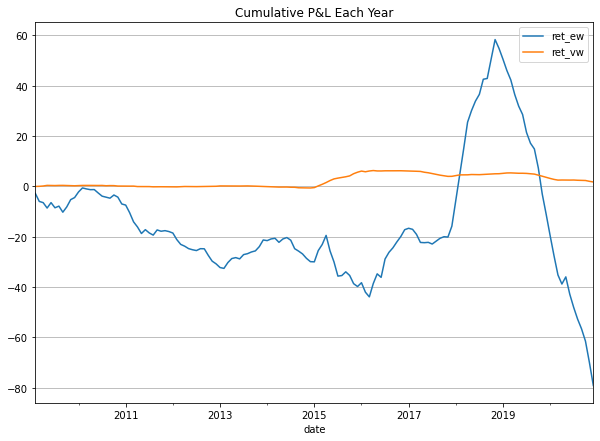

In [48]:
# Visualize profit & loss each year
plot_cum_ret(pnl.reset_index())

#### Replicate table 3 panel A

In [49]:
# Equally-weighted portfolio
df_add_title(PC_ranks_ew, 'Panel A for %s Equally-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.144611,0.049933,0.094678
Component_20~39,0.046813,-0.006318,0.053131
Component_40~59,0.024624,0.004602,0.020023
Component_60~79,0.002630,-0.000253,0.002882
Component_80~99,-0.001697,0.000754,-0.002451


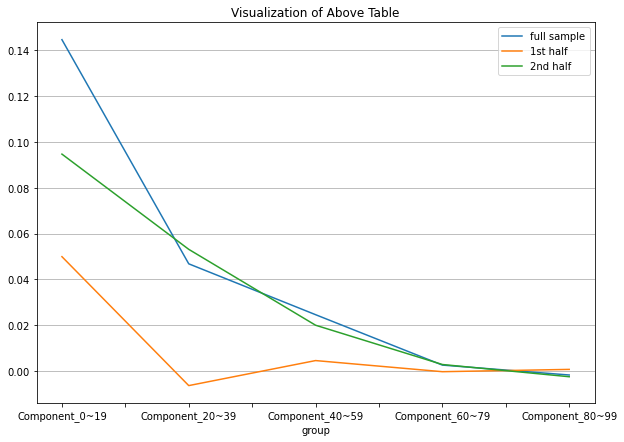

In [50]:
# Visualize above table
plot_PC_ret(PC_ranks_ew)

In [51]:
# Value-weighted portfolio
df_add_title(PC_ranks_vw, 'Panel A for %s Value-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.005124,-0.008858,0.013983
Component_20~39,0.000081,-0.000498,0.000579
Component_40~59,0.000394,0.000229,0.000164
Component_60~79,0.000429,0.000145,0.000284
Component_80~99,0.000120,0.000061,0.000059


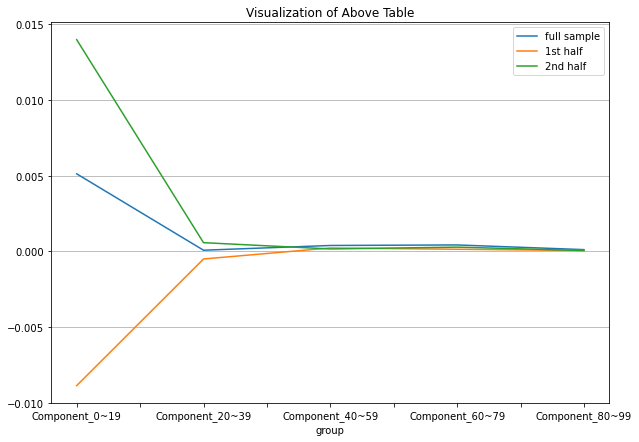

In [52]:
# Visualize above table
plot_PC_ret(PC_ranks_vw)

#### Replicate table 3 panel B

In [53]:
# Equally-weighted portfolio
df_add_title(panelB_ew, 'Panel B for %s Equally-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,-0.00109 (0.10877),-0.00023 (0.35849),-0.00009 (0.35654),-0.00002 (0.26738)
mkt_rf,-0.00532 (0.46642),-0.00086 (0.53819),0.00045 (0.53095),0.00018 (0.51071)
smb,-0.00512 (0.54004),-0.00006 (0.55749),0.00054 (0.54116),-0.00063 (0.45467)
hml,0.00226 (0.51639),-0.00237 (0.51070),-0.00031 (0.49242),-0.00024 (0.42275)
rmw,-0.00967 (0.45613),0.00203 (0.56326),0.00220 (0.37741),0.00071 (0.50890)
cma,0.00211 (0.61706),-0.00116 (0.45815),-0.00088 (0.46283),0.00001 (0.47288)
alpha_1st,0.33343 (0.02011),0.11056 (0.10729),0.02920 (0.30154),0.00306 (0.53440)
alpha_2nd,0.20519 (0.01487),0.06449 (0.09232),0.01059 (0.45328),0.00084 (0.56548)
Component_0_19,0.08736 (0.02321),0.02815 (0.11915),0.00551 (0.47281),0.00047 (0.65547)
adj. R sq,0.11896,0.04112,0.00219,0.00295


In [54]:
# Value-weighted portfolio
df_add_title(panelB_vw, 'Panel B for %s Value-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,-0.00002 (0.27018),0.00000 (0.50759),0.00000 (0.31895),0.00000 (0.24274)
mkt_rf,0.00039 (0.40473),0.00005 (0.40421),-0.00000 (0.46653),-0.00000 (0.51576)
smb,0.00053 (0.46850),0.00009 (0.52661),0.00001 (0.55624),0.00001 (0.48686)
hml,-0.00002 (0.46851),-0.00018 (0.41362),0.00000 (0.47815),0.00000 (0.53813)
rmw,0.00052 (0.41124),0.00015 (0.40548),0.00002 (0.39519),0.00001 (0.57588)
cma,-0.00018 (0.51029),0.00005 (0.54806),0.00003 (0.51458),0.00001 (0.49154)
alpha_1st,0.07722 (0.15166),0.01746 (0.33204),0.00224 (0.60774),0.00010 (0.77467)
alpha_2nd,0.10037 (0.05032),0.01200 (0.43673),0.00101 (0.67571),0.00012 (0.74025)
Component_0_19,0.01243 (0.23175),0.00164 (0.64154),0.00028 (0.81878),0.00003 (0.89617)
adj. R sq,0.07418,-0.00062,-0.01225,-0.01641


#### Replicate table 3 panel C

In [55]:
df_add_title(panelC_ew, 'Panel C for %s Equally-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00721 (0.00000),-0.00714 (0.00000),-0.00704 (0.00000),-0.00699 (0.00000),-0.00699 (0.00000)
mkt_rf,-0.01254 (0.43132),-0.01164 (0.46085),-0.01137 (0.46591),-0.01181 (0.45197),-0.01267 (0.44430)
smb,-0.01004 (0.53776),-0.01036 (0.51445),-0.01090 (0.51986),-0.00990 (0.51052),-0.01029 (0.51429)
hml,0.02692 (0.38871),0.02750 (0.36145),0.02681 (0.35455),0.02743 (0.34709),0.02816 (0.34966)
rmw,-0.02185 (0.47070),-0.02247 (0.46371),-0.02032 (0.48203),-0.02096 (0.47309),-0.02298 (0.46536)
cma,0.01751 (0.61183),0.01963 (0.59773),0.02013 (0.59968),0.01976 (0.61484),0.01818 (0.61810)
alpha_1st,1.44058 (0.00000),1.40912 (0.00000),1.40487 (0.00000),1.40285 (0.00000),1.42722 (0.00000)
alpha_2nd,1.20797 (0.00000),1.23095 (0.00000),1.22587 (0.00000),1.22718 (0.00000),1.22975 (0.00000)
Component_20_39,0.62368 (0.00718),nan,nan,nan,0.15048 (0.33656)
Component_40_59,nan,0.60140 (0.14623),nan,nan,0.12268 (0.54711)


In [56]:
df_add_title(panelC_vw, 'Panel C for %s Value-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00038 (0.00001),-0.00037 (0.00001),-0.00037 (0.00001),-0.00037 (0.00002),-0.00036 (0.00007)
mkt_rf,0.00023 (0.56903),0.00022 (0.62408),0.00020 (0.62560),0.00021 (0.63487),0.00030 (0.59475)
smb,0.00233 (0.47664),0.00205 (0.49522),0.00202 (0.49104),0.00201 (0.48877),0.00222 (0.49480)
hml,-0.00037 (0.63217),-0.00059 (0.65767),-0.00064 (0.65488),-0.00065 (0.65890),-0.00056 (0.67392)
rmw,0.00207 (0.42438),0.00194 (0.44732),0.00191 (0.43564),0.00193 (0.44786),0.00211 (0.42768)
cma,0.00107 (0.66224),0.00116 (0.68175),0.00133 (0.65137),0.00132 (0.65485),0.00109 (0.66527)
alpha_1st,1.24639 (0.00395),1.27642 (0.00274),1.27983 (0.00232),1.27419 (0.00257),1.28419 (0.00288)
alpha_2nd,1.05125 (0.00000),1.04686 (0.00000),1.04728 (0.00000),1.04649 (0.00000),1.04985 (0.00000)
Component_20_39,0.24342 (0.41116),nan,nan,nan,-0.08757 (0.61922)
Component_40_59,nan,0.23438 (0.61580),nan,nan,-0.11734 (0.67634)


#### Sharpe ratio

In [57]:
# Evaluate Sharpe ratio.
df_add_title(sharpe(pnl, ff5), 'Sharpe Ratio of Such Strategy in %s' % region)

,Annualized Sharpe Ratio
ret_ew,-0.506176
ret_vw,0.190140


### (b) HK

In [58]:
region = 'HK'

In [59]:
%%time
# calculate PnL each year, non-cumulative version
pnl, PC_ranks_ew, PC_ranks_vw, panelB_ew, panelB_vw, panelC_ew, panelC_vw = compute_pnl(tradeable_data[region.lower()], ff5)

Wall time: 29min 31s


#### Simple, non-compounding accumulative P&L 

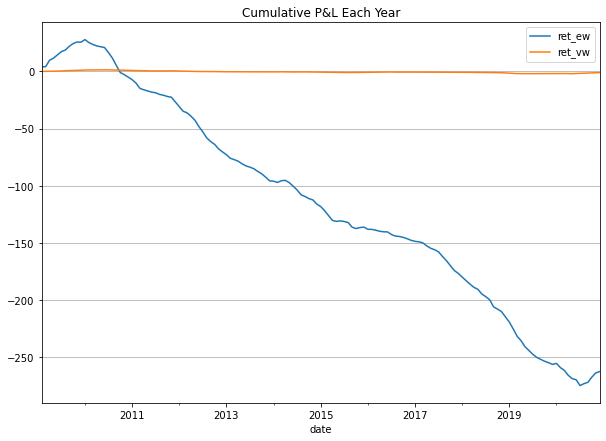

In [60]:
# Visualize profit & loss each year
plot_cum_ret(pnl.reset_index())

#### Replicate table 3 panel A

In [61]:
# Equally-weighted portfolio
df_add_title(PC_ranks_ew, 'Panel A for %s Equally-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.553805,0.369072,0.184732
Component_20~39,-0.013925,0.011158,-0.025083
Component_40~59,0.001283,-0.000780,0.002063
Component_60~79,0.006454,0.002442,0.004012
Component_80~99,0.001711,-0.000286,0.001997


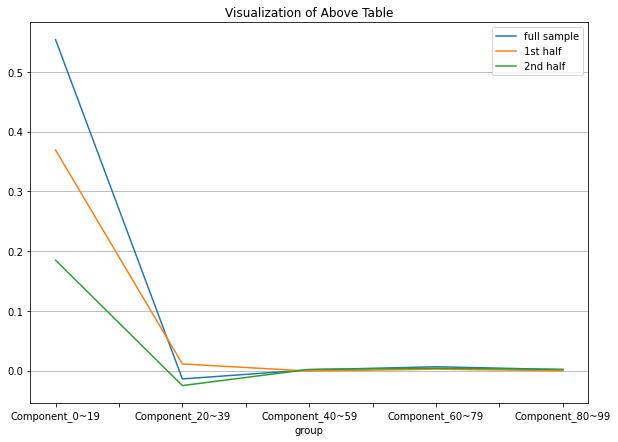

In [62]:
# Visualize above table
plot_PC_ret(PC_ranks_ew)

In [63]:
# Value-weighted portfolio
df_add_title(PC_ranks_vw, 'Panel A for %s Value-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.032214,0.019279,0.012935
Component_20~39,0.001377,0.000217,0.001161
Component_40~59,0.000570,0.000270,0.000299
Component_60~79,0.000305,0.000113,0.000192
Component_80~99,0.000141,0.000061,0.000080


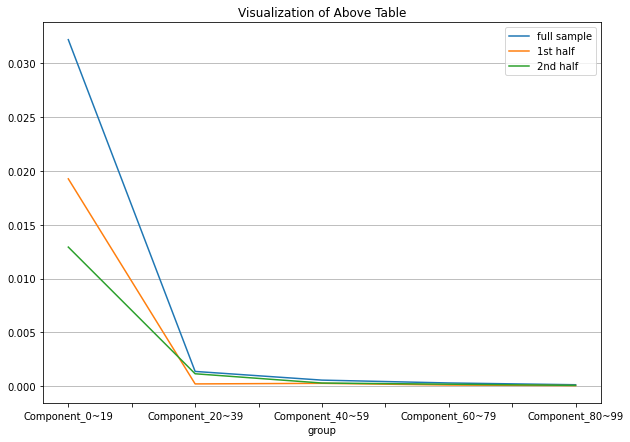

In [64]:
# Visualize above table
plot_PC_ret(PC_ranks_vw)

#### Replicate table 3 panel B

In [65]:
# Equally-weighted portfolio
df_add_title(panelB_ew, 'Panel B for %s Equally-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,-0.00236 (0.02280),-0.00052 (0.26669),-0.00018 (0.30417),-0.00004 (0.22803)
mkt_rf,0.00077 (0.54386),0.00005 (0.49024),0.00253 (0.38184),0.00061 (0.45282)
smb,-0.00193 (0.63619),-0.00585 (0.51415),0.00012 (0.45090),-0.00011 (0.40411)
hml,-0.00536 (0.42502),0.00504 (0.50896),-0.00511 (0.38201),0.00037 (0.57400)
rmw,-0.00457 (0.52406),0.00255 (0.51603),0.00536 (0.41075),0.00043 (0.43191)
cma,-0.01824 (0.49254),-0.00505 (0.50013),0.00544 (0.41116),-0.00045 (0.53026)
alpha_1st,0.38354 (0.00497),0.08676 (0.20363),0.03427 (0.27890),0.00839 (0.41851)
alpha_2nd,0.35420 (0.00545),0.10450 (0.09809),0.02603 (0.33483),0.00710 (0.45141)
Component_0_19,0.10756 (0.01271),0.02819 (0.17010),0.00911 (0.37391),0.00228 (0.54569)
adj. R sq,0.14433,0.03288,0.01135,-0.00360


In [66]:
# Value-weighted portfolio
df_add_title(panelB_vw, 'Panel B for %s Value-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,-0.00002 (0.33965),-0.00000 (0.51080),0.00000 (0.47284),0.00000 (0.23909)
mkt_rf,0.00008 (0.62650),0.00009 (0.51091),0.00004 (0.45371),0.00000 (0.54053)
smb,0.00005 (0.44468),0.00003 (0.53810),-0.00003 (0.48344),0.00002 (0.40436)
hml,0.00023 (0.44157),-0.00013 (0.52117),-0.00005 (0.55132),-0.00001 (0.58038)
rmw,-0.00005 (0.55512),0.00011 (0.52711),0.00003 (0.46292),0.00002 (0.45764)
cma,-0.00013 (0.44244),0.00023 (0.50437),0.00007 (0.52369),0.00003 (0.51468)
alpha_1st,0.26552 (0.05397),0.07255 (0.17055),0.01575 (0.38528),0.00183 (0.57214)
alpha_2nd,0.26698 (0.03754),0.05632 (0.17862),0.01071 (0.51605),0.00196 (0.60730)
Component_0_19,0.02714 (0.12860),0.00595 (0.44056),0.00123 (0.68767),0.00013 (0.80792)
adj. R sq,0.13475,0.02160,-0.00486,-0.01422


#### Replicate table 3 panel C

In [67]:
df_add_title(panelC_ew, 'Panel C for %s Equally-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00755 (0.00000),-0.00711 (0.00000),-0.00711 (0.00000),-0.00701 (0.00000),-0.00712 (0.00000)
mkt_rf,-0.00622 (0.59549),-0.00577 (0.57147),-0.00472 (0.54595),-0.00541 (0.54971),-0.00589 (0.56148)
smb,-0.00753 (0.52608),-0.00995 (0.49973),-0.01122 (0.45835),-0.01049 (0.46563),-0.00812 (0.50022)
hml,-0.00166 (0.56266),-0.00305 (0.62537),-0.00196 (0.60290),-0.00190 (0.58645),-0.00190 (0.59293)
rmw,-0.01374 (0.51351),-0.01310 (0.50754),-0.01114 (0.53761),-0.01132 (0.54284),-0.01291 (0.51361)
cma,-0.00266 (0.61829),-0.00319 (0.62431),-0.00389 (0.60496),-0.00320 (0.62604),-0.00492 (0.61525)
alpha_1st,1.15540 (0.00000),1.15347 (0.00000),1.15808 (0.00000),1.15695 (0.00000),1.16111 (0.00000)
alpha_2nd,1.25933 (0.00000),1.29192 (0.00000),1.29354 (0.00000),1.29597 (0.00000),1.29867 (0.00000)
Component_20_39,0.68709 (0.00003),nan,nan,nan,0.18236 (0.19188)
Component_40_59,nan,0.72691 (0.02650),nan,nan,0.20034 (0.33558)


In [68]:
df_add_title(panelC_vw, 'Panel C for %s Value-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00013 (0.00005),-0.00012 (0.00006),-0.00012 (0.00007),-0.00012 (0.00028),-0.00011 (0.00061)
mkt_rf,0.00032 (0.60393),0.00024 (0.64319),0.00020 (0.65888),0.00020 (0.66406),0.00022 (0.64632)
smb,0.00020 (0.52059),0.00022 (0.53302),0.00019 (0.54457),0.00021 (0.53981),0.00018 (0.52531)
hml,-0.00129 (0.32684),-0.00104 (0.32249),-0.00098 (0.33749),-0.00098 (0.33692),-0.00105 (0.35056)
rmw,-0.00028 (0.45059),-0.00057 (0.44376),-0.00057 (0.45008),-0.00058 (0.44810),-0.00049 (0.46330)
cma,0.00135 (0.35999),0.00125 (0.34451),0.00123 (0.34828),0.00124 (0.34239),0.00118 (0.36863)
alpha_1st,1.03024 (0.00000),1.03504 (0.00000),1.03487 (0.00000),1.03437 (0.00000),1.03531 (0.00000)
alpha_2nd,1.06914 (0.00000),1.07802 (0.00000),1.08991 (0.00000),1.08291 (0.00000),1.08841 (0.00000)
Component_20_39,0.56646 (0.00202),nan,nan,nan,0.16041 (0.27317)
Component_40_59,nan,0.47666 (0.15384),nan,nan,0.03229 (0.62450)


#### Sharpe ratio

In [69]:
# Evaluate Sharpe ratio.
df_add_title(sharpe(pnl, ff5), 'Sharpe Ratio of Such Strategy in %s' % region)

,Annualized Sharpe Ratio
ret_ew,-2.804881
ret_vw,-0.327989


### (c) US

In [70]:
region = 'US'

In [71]:
%%time
# calculate PnL each year, non-cumulative version
pnl, PC_ranks_ew, PC_ranks_vw, panelB_ew, panelB_vw, panelC_ew, panelC_vw = compute_pnl(tradeable_data[region.lower()], ff5)

Wall time: 40min 46s


#### Simple, non-compounding accumulative P&L 

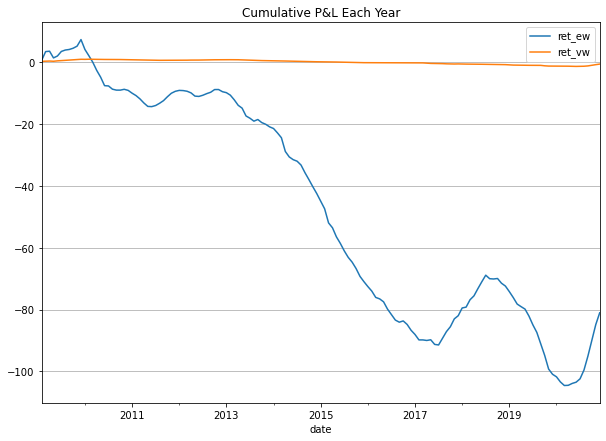

In [72]:
# Visualize profit & loss each year
plot_cum_ret(pnl.reset_index())

#### Replicate table 3 panel A

In [73]:
# Equally-weighted portfolio
df_add_title(PC_ranks_ew, 'Panel A for %s Equally-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.082400,0.051403,0.030997
Component_20~39,0.017894,0.014222,0.003671
Component_40~59,0.008421,0.001979,0.006442
Component_60~79,-0.000822,-0.000566,-0.000256
Component_80~99,-0.000250,-0.000798,0.000548


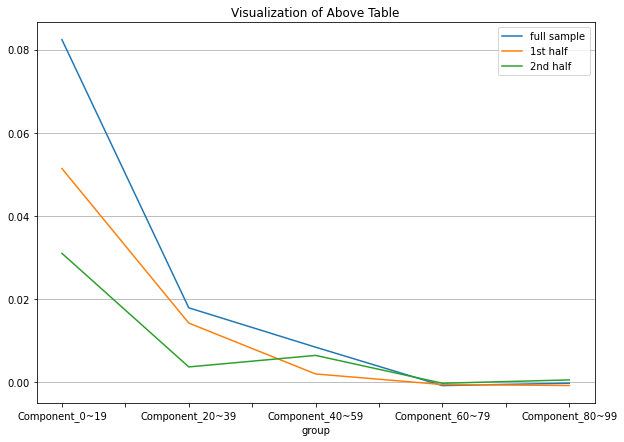

In [74]:
# Visualize above table
plot_PC_ret(PC_ranks_ew)

In [75]:
# Value-weighted portfolio
df_add_title(PC_ranks_vw, 'Panel A for %s Value-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.012851,0.010667,0.002184
Component_20~39,0.001419,0.000716,0.000702
Component_40~59,0.000338,0.000234,0.000104
Component_60~79,0.000096,0.000059,0.000036
Component_80~99,0.000031,0.000005,0.000026


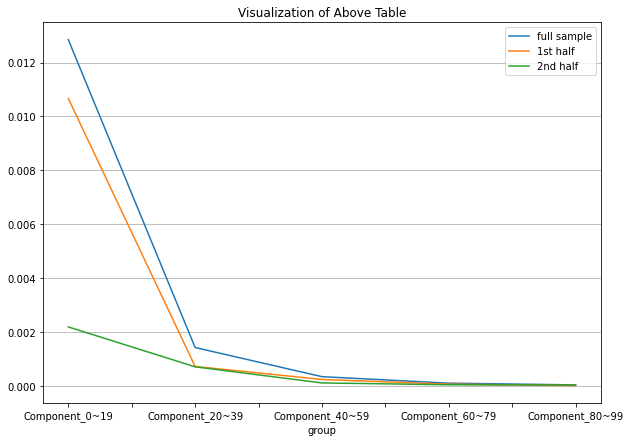

In [76]:
# Visualize above table
plot_PC_ret(PC_ranks_vw)

#### Replicate table 3 panel B

In [77]:
# Equally-weighted portfolio
df_add_title(panelB_ew, 'Panel B for %s Equally-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,-0.00079 (0.06432),-0.00011 (0.38165),-0.00007 (0.38497),-0.00001 (0.24683)
mkt_rf,-0.00812 (0.28769),-0.00238 (0.37280),-0.00059 (0.51336),0.00006 (0.59405)
smb,0.00171 (0.58964),0.00142 (0.45529),0.00082 (0.48998),-0.00049 (0.49355)
hml,0.00347 (0.50597),0.00088 (0.47592),-0.00116 (0.40672),0.00003 (0.61210)
rmw,-0.00579 (0.42115),-0.00358 (0.41611),0.00003 (0.52270),-0.00048 (0.56163)
cma,0.00368 (0.54372),0.00067 (0.53617),0.00013 (0.46850),0.00003 (0.61710)
alpha_1st,0.20036 (0.00843),0.04138 (0.25757),0.01198 (0.39039),0.00194 (0.54113)
alpha_2nd,0.30236 (0.00634),0.09518 (0.07434),0.01321 (0.50535),0.00411 (0.47635)
Component_0_19,0.04308 (0.06008),0.01076 (0.34831),0.00251 (0.58613),0.00063 (0.68195)
adj. R sq,0.12705,0.03407,0.00303,-0.02022


In [78]:
# Value-weighted portfolio
df_add_title(panelB_vw, 'Panel B for %s Value-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,0.00000 (0.49861),0.00000 (0.44793),0.00000 (0.47481),0.00000 (0.17464)
mkt_rf,-0.00002 (0.56569),0.00001 (0.51366),0.00001 (0.49767),-0.00000 (0.53724)
smb,0.00001 (0.59604),-0.00007 (0.47281),0.00000 (0.62636),-0.00000 (0.48628)
hml,0.00020 (0.38851),0.00007 (0.30318),0.00000 (0.50320),0.00001 (0.49473)
rmw,0.00005 (0.39791),-0.00003 (0.54051),0.00002 (0.39446),-0.00001 (0.46838)
cma,-0.00030 (0.43819),0.00006 (0.44802),-0.00000 (0.54765),-0.00001 (0.48769)
alpha_1st,0.17618 (0.02598),0.02795 (0.30030),0.00623 (0.49022),0.00119 (0.62147)
alpha_2nd,0.13047 (0.13337),0.03583 (0.25688),0.00507 (0.52723),0.00161 (0.55927)
Component_0_19,0.01228 (0.25170),0.00250 (0.52978),0.00050 (0.72639),0.00008 (0.83702)
adj. R sq,0.08446,0.01594,-0.01317,-0.01679


#### Replicate table 3 panel C

In [79]:
df_add_title(panelC_ew, 'Panel C for %s Equally-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00415 (0.00000),-0.00396 (0.00000),-0.00391 (0.00000),-0.00393 (0.00000),-0.00391 (0.00000)
mkt_rf,-0.00279 (0.58652),0.00008 (0.62096),-0.00099 (0.62886),-0.00094 (0.61689),-0.00121 (0.61805)
smb,0.00126 (0.59910),-0.00046 (0.57450),-0.00146 (0.58987),-0.00079 (0.59633),-0.00094 (0.59133)
hml,0.00762 (0.60259),0.00185 (0.61115),0.00183 (0.63738),0.00202 (0.62985),0.00376 (0.62992)
rmw,-0.00751 (0.49682),-0.00721 (0.47307),-0.00966 (0.48338),-0.00905 (0.48701),-0.00811 (0.47626)
cma,-0.02927 (0.33399),-0.02177 (0.44579),-0.02096 (0.45593),-0.02134 (0.44263),-0.02366 (0.41917)
alpha_1st,1.06807 (0.00000),1.07145 (0.00000),1.07109 (0.00000),1.07106 (0.00000),1.07245 (0.00000)
alpha_2nd,1.30395 (0.00000),1.33063 (0.00000),1.33409 (0.00000),1.33662 (0.00000),1.34026 (0.00000)
Component_20_39,0.54683 (0.00145),nan,nan,nan,0.12960 (0.40889)
Component_40_59,nan,0.53137 (0.17409),nan,nan,0.12552 (0.44594)


In [80]:
df_add_title(panelC_vw, 'Panel C for %s Value-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00007 (0.00000),-0.00007 (0.00001),-0.00007 (0.00001),-0.00007 (0.00003),-0.00006 (0.00007)
mkt_rf,0.00034 (0.30818),0.00034 (0.29246),0.00033 (0.30862),0.00033 (0.30557),0.00034 (0.29744)
smb,-0.00040 (0.45707),-0.00042 (0.39129),-0.00043 (0.37731),-0.00043 (0.37804),-0.00043 (0.40043)
hml,0.00110 (0.04255),0.00114 (0.03006),0.00116 (0.02678),0.00116 (0.02734),0.00115 (0.03109)
rmw,0.00004 (0.56327),0.00003 (0.53504),0.00002 (0.50142),0.00001 (0.51907),0.00002 (0.53860)
cma,-0.00054 (0.47201),-0.00050 (0.46812),-0.00054 (0.42455),-0.00054 (0.42661),-0.00052 (0.45936)
alpha_1st,1.03605 (0.00000),1.04114 (0.00000),1.04033 (0.00000),1.04001 (0.00000),1.04035 (0.00000)
alpha_2nd,1.09318 (0.00000),1.07718 (0.00000),1.07878 (0.00000),1.07955 (0.00000),1.09062 (0.00000)
Component_20_39,0.50581 (0.03769),nan,nan,nan,0.10843 (0.34794)
Component_40_59,nan,0.37433 (0.37114),nan,nan,-0.02683 (0.53949)


#### Sharpe ratio

In [81]:
# Evaluate Sharpe ratio.
df_add_title(sharpe(pnl, ff5), 'Sharpe Ratio of Such Strategy in %s' % region)

,Annualized Sharpe Ratio
ret_ew,-1.115982
ret_vw,-0.376670


## Case 2: Transaction cost = 50% of portfolio return

In [82]:
cost = 0.5

### (a) China

In [83]:
region = 'China'

In [84]:
%%time
# calculate PnL each year, non-cumulative version
pnl, PC_ranks_ew, PC_ranks_vw, panelB_ew, panelB_vw, panelC_ew, panelC_vw = compute_pnl(tradeable_data[region.lower()], ff5, cost)

Wall time: 53min 15s


#### Simple, non-compounding accumulative P&L 

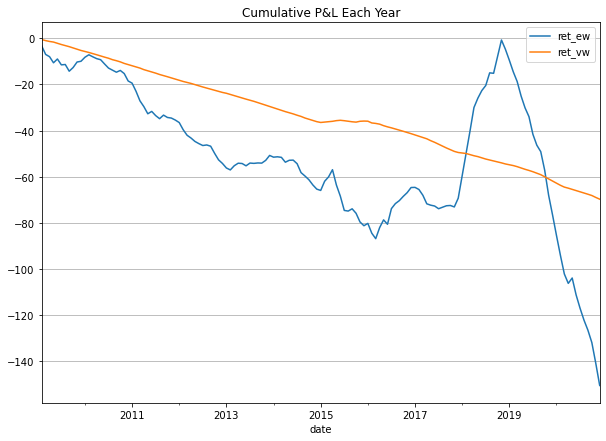

In [85]:
# Visualize profit & loss each year
plot_cum_ret(pnl.reset_index())

#### Replicate table 3 panel A

In [86]:
# Equally-weighted portfolio
df_add_title(PC_ranks_ew, 'Panel A for %s Equally-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.144611,0.049933,0.094678
Component_20~39,0.046813,-0.006318,0.053131
Component_40~59,0.024624,0.004602,0.020023
Component_60~79,0.002630,-0.000253,0.002882
Component_80~99,-0.001697,0.000754,-0.002451


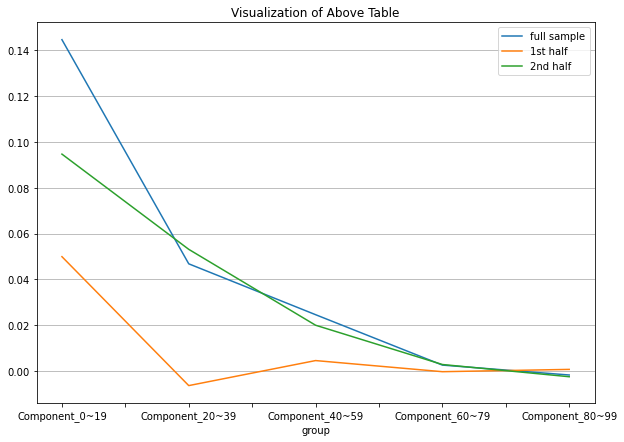

In [87]:
# Visualize above table
plot_PC_ret(PC_ranks_ew)

In [88]:
# Value-weighted portfolio
df_add_title(PC_ranks_vw, 'Panel A for %s Value-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.005124,-0.008858,0.013983
Component_20~39,0.000081,-0.000498,0.000579
Component_40~59,0.000394,0.000229,0.000164
Component_60~79,0.000429,0.000145,0.000284
Component_80~99,0.000120,0.000061,0.000059


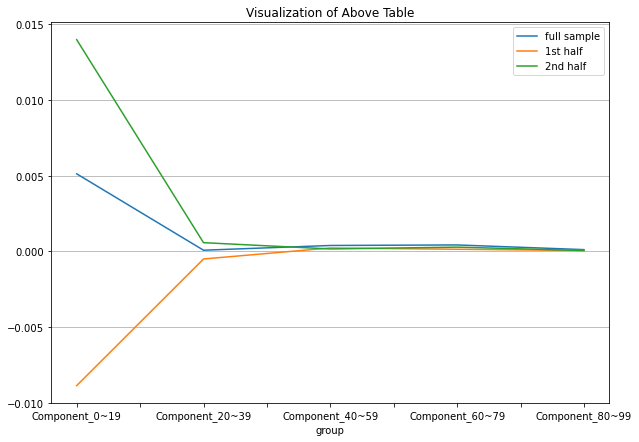

In [89]:
# Visualize above table
plot_PC_ret(PC_ranks_vw)

#### Replicate table 3 panel B

In [90]:
# Equally-weighted portfolio
df_add_title(panelB_ew, 'Panel B for %s Equally-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,-0.00109 (0.10877),-0.00023 (0.35849),-0.00009 (0.35654),-0.00002 (0.26738)
mkt_rf,-0.00532 (0.46642),-0.00086 (0.53819),0.00045 (0.53095),0.00018 (0.51071)
smb,-0.00512 (0.54004),-0.00006 (0.55749),0.00054 (0.54116),-0.00063 (0.45467)
hml,0.00226 (0.51639),-0.00237 (0.51070),-0.00031 (0.49242),-0.00024 (0.42275)
rmw,-0.00967 (0.45613),0.00203 (0.56326),0.00220 (0.37741),0.00071 (0.50890)
cma,0.00211 (0.61706),-0.00116 (0.45815),-0.00088 (0.46283),0.00001 (0.47288)
alpha_1st,0.33343 (0.02011),0.11056 (0.10729),0.02920 (0.30154),0.00306 (0.53440)
alpha_2nd,0.20519 (0.01487),0.06449 (0.09232),0.01059 (0.45328),0.00084 (0.56548)
Component_0_19,0.08736 (0.02321),0.02815 (0.11915),0.00551 (0.47281),0.00047 (0.65547)
adj. R sq,0.11896,0.04112,0.00219,0.00295


In [91]:
# Value-weighted portfolio
df_add_title(panelB_vw, 'Panel B for %s Value-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,-0.00002 (0.27018),0.00000 (0.50759),0.00000 (0.31895),0.00000 (0.24274)
mkt_rf,0.00039 (0.40473),0.00005 (0.40421),-0.00000 (0.46653),-0.00000 (0.51576)
smb,0.00053 (0.46850),0.00009 (0.52661),0.00001 (0.55624),0.00001 (0.48686)
hml,-0.00002 (0.46851),-0.00018 (0.41362),0.00000 (0.47815),0.00000 (0.53813)
rmw,0.00052 (0.41124),0.00015 (0.40548),0.00002 (0.39519),0.00001 (0.57588)
cma,-0.00018 (0.51029),0.00005 (0.54806),0.00003 (0.51458),0.00001 (0.49154)
alpha_1st,0.07722 (0.15166),0.01746 (0.33204),0.00224 (0.60774),0.00010 (0.77467)
alpha_2nd,0.10037 (0.05032),0.01200 (0.43673),0.00101 (0.67571),0.00012 (0.74025)
Component_0_19,0.01243 (0.23175),0.00164 (0.64154),0.00028 (0.81878),0.00003 (0.89617)
adj. R sq,0.07418,-0.00062,-0.01225,-0.01641


#### Replicate table 3 panel C

In [92]:
df_add_title(panelC_ew, 'Panel C for %s Equally-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00721 (0.00000),-0.00714 (0.00000),-0.00704 (0.00000),-0.00699 (0.00000),-0.00699 (0.00000)
mkt_rf,-0.01254 (0.43132),-0.01164 (0.46085),-0.01137 (0.46591),-0.01181 (0.45197),-0.01267 (0.44430)
smb,-0.01004 (0.53776),-0.01036 (0.51445),-0.01090 (0.51986),-0.00990 (0.51052),-0.01029 (0.51429)
hml,0.02692 (0.38871),0.02750 (0.36145),0.02681 (0.35455),0.02743 (0.34709),0.02816 (0.34966)
rmw,-0.02185 (0.47070),-0.02247 (0.46371),-0.02032 (0.48203),-0.02096 (0.47309),-0.02298 (0.46536)
cma,0.01751 (0.61183),0.01963 (0.59773),0.02013 (0.59968),0.01976 (0.61484),0.01818 (0.61810)
alpha_1st,1.44058 (0.00000),1.40912 (0.00000),1.40487 (0.00000),1.40285 (0.00000),1.42722 (0.00000)
alpha_2nd,1.20797 (0.00000),1.23095 (0.00000),1.22587 (0.00000),1.22718 (0.00000),1.22975 (0.00000)
Component_20_39,0.62368 (0.00718),nan,nan,nan,0.15048 (0.33656)
Component_40_59,nan,0.60140 (0.14623),nan,nan,0.12268 (0.54711)


In [93]:
df_add_title(panelC_vw, 'Panel C for %s Value-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00038 (0.00001),-0.00037 (0.00001),-0.00037 (0.00001),-0.00037 (0.00002),-0.00036 (0.00007)
mkt_rf,0.00023 (0.56903),0.00022 (0.62408),0.00020 (0.62560),0.00021 (0.63487),0.00030 (0.59475)
smb,0.00233 (0.47664),0.00205 (0.49522),0.00202 (0.49104),0.00201 (0.48877),0.00222 (0.49480)
hml,-0.00037 (0.63217),-0.00059 (0.65767),-0.00064 (0.65488),-0.00065 (0.65890),-0.00056 (0.67392)
rmw,0.00207 (0.42438),0.00194 (0.44732),0.00191 (0.43564),0.00193 (0.44786),0.00211 (0.42768)
cma,0.00107 (0.66224),0.00116 (0.68175),0.00133 (0.65137),0.00132 (0.65485),0.00109 (0.66527)
alpha_1st,1.24639 (0.00395),1.27642 (0.00274),1.27983 (0.00232),1.27419 (0.00257),1.28419 (0.00288)
alpha_2nd,1.05125 (0.00000),1.04686 (0.00000),1.04728 (0.00000),1.04649 (0.00000),1.04985 (0.00000)
Component_20_39,0.24342 (0.41116),nan,nan,nan,-0.08757 (0.61922)
Component_40_59,nan,0.23438 (0.61580),nan,nan,-0.11734 (0.67634)


#### Sharpe ratio

In [94]:
# Evaluate Sharpe ratio.
df_add_title(sharpe(pnl, ff5), 'Sharpe Ratio of Such Strategy in %s' % region)

,Annualized Sharpe Ratio
ret_ew,-0.963612
ret_vw,-7.814396


### (b) HK

In [95]:
region = 'HK'

In [96]:
%%time
# calculate PnL each year, non-cumulative version
pnl, PC_ranks_ew, PC_ranks_vw, panelB_ew, panelB_vw, panelC_ew, panelC_vw = compute_pnl(tradeable_data[region.lower()], ff5, cost)

Wall time: 51min 22s


#### Simple, non-compounding accumulative P&L 

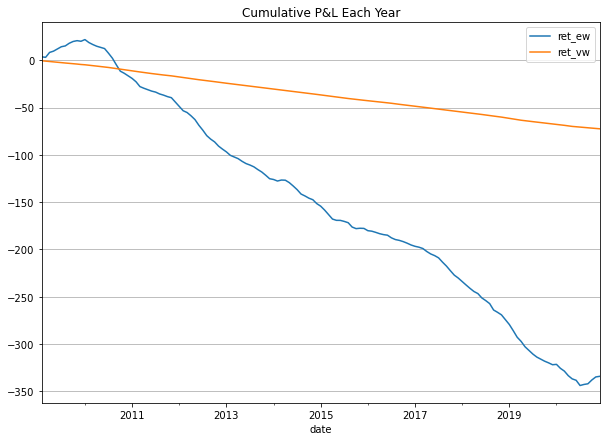

In [97]:
# Visualize profit & loss each year
plot_cum_ret(pnl.reset_index())

#### Replicate table 3 panel A

In [98]:
# Equally-weighted portfolio
df_add_title(PC_ranks_ew, 'Panel A for %s Equally-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.553805,0.369072,0.184732
Component_20~39,-0.013925,0.011158,-0.025083
Component_40~59,0.001283,-0.000780,0.002063
Component_60~79,0.006454,0.002442,0.004012
Component_80~99,0.001711,-0.000286,0.001997


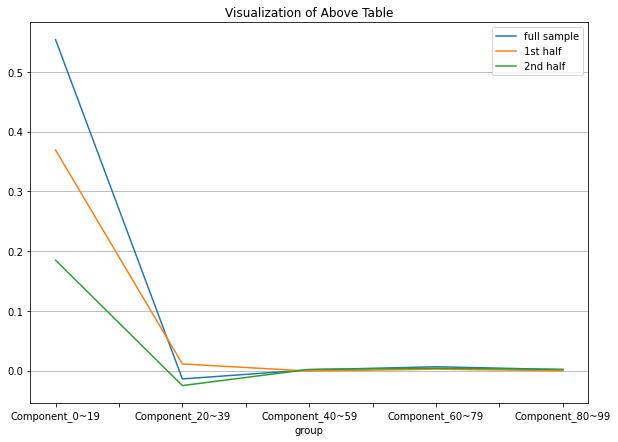

In [99]:
# Visualize above table
plot_PC_ret(PC_ranks_ew)

In [100]:
# Value-weighted portfolio
df_add_title(PC_ranks_vw, 'Panel A for %s Value-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.032214,0.019279,0.012935
Component_20~39,0.001377,0.000217,0.001161
Component_40~59,0.000570,0.000270,0.000299
Component_60~79,0.000305,0.000113,0.000192
Component_80~99,0.000141,0.000061,0.000080


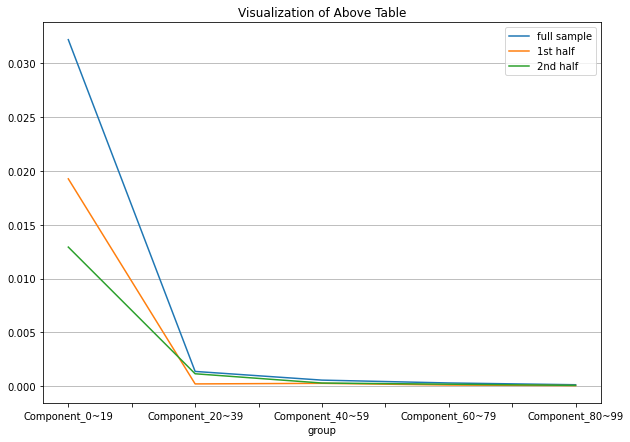

In [101]:
# Visualize above table
plot_PC_ret(PC_ranks_vw)

#### Replicate table 3 panel B

In [102]:
# Equally-weighted portfolio
df_add_title(panelB_ew, 'Panel B for %s Equally-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,-0.00236 (0.02280),-0.00052 (0.26669),-0.00018 (0.30417),-0.00004 (0.22803)
mkt_rf,0.00077 (0.54386),0.00005 (0.49024),0.00253 (0.38184),0.00061 (0.45282)
smb,-0.00193 (0.63619),-0.00585 (0.51415),0.00012 (0.45090),-0.00011 (0.40411)
hml,-0.00536 (0.42502),0.00504 (0.50896),-0.00511 (0.38201),0.00037 (0.57400)
rmw,-0.00457 (0.52406),0.00255 (0.51603),0.00536 (0.41075),0.00043 (0.43191)
cma,-0.01824 (0.49254),-0.00505 (0.50013),0.00544 (0.41116),-0.00045 (0.53026)
alpha_1st,0.38354 (0.00497),0.08676 (0.20363),0.03427 (0.27890),0.00839 (0.41851)
alpha_2nd,0.35420 (0.00545),0.10450 (0.09809),0.02603 (0.33483),0.00710 (0.45141)
Component_0_19,0.10756 (0.01271),0.02819 (0.17010),0.00911 (0.37391),0.00228 (0.54569)
adj. R sq,0.14433,0.03288,0.01135,-0.00360


In [103]:
# Value-weighted portfolio
df_add_title(panelB_vw, 'Panel B for %s Value-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,-0.00002 (0.33965),-0.00000 (0.51080),0.00000 (0.47284),0.00000 (0.23909)
mkt_rf,0.00008 (0.62650),0.00009 (0.51091),0.00004 (0.45371),0.00000 (0.54053)
smb,0.00005 (0.44468),0.00003 (0.53810),-0.00003 (0.48344),0.00002 (0.40436)
hml,0.00023 (0.44157),-0.00013 (0.52117),-0.00005 (0.55132),-0.00001 (0.58038)
rmw,-0.00005 (0.55512),0.00011 (0.52711),0.00003 (0.46292),0.00002 (0.45764)
cma,-0.00013 (0.44244),0.00023 (0.50437),0.00007 (0.52369),0.00003 (0.51468)
alpha_1st,0.26552 (0.05397),0.07255 (0.17055),0.01575 (0.38528),0.00183 (0.57214)
alpha_2nd,0.26698 (0.03754),0.05632 (0.17862),0.01071 (0.51605),0.00196 (0.60730)
Component_0_19,0.02714 (0.12860),0.00595 (0.44056),0.00123 (0.68767),0.00013 (0.80792)
adj. R sq,0.13475,0.02160,-0.00486,-0.01422


#### Replicate table 3 panel C

In [104]:
df_add_title(panelC_ew, 'Panel C for %s Equally-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00755 (0.00000),-0.00711 (0.00000),-0.00711 (0.00000),-0.00701 (0.00000),-0.00712 (0.00000)
mkt_rf,-0.00622 (0.59549),-0.00577 (0.57147),-0.00472 (0.54595),-0.00541 (0.54971),-0.00589 (0.56148)
smb,-0.00753 (0.52608),-0.00995 (0.49973),-0.01122 (0.45835),-0.01049 (0.46563),-0.00812 (0.50022)
hml,-0.00166 (0.56266),-0.00305 (0.62537),-0.00196 (0.60290),-0.00190 (0.58645),-0.00190 (0.59293)
rmw,-0.01374 (0.51351),-0.01310 (0.50754),-0.01114 (0.53761),-0.01132 (0.54284),-0.01291 (0.51361)
cma,-0.00266 (0.61829),-0.00319 (0.62431),-0.00389 (0.60496),-0.00320 (0.62604),-0.00492 (0.61525)
alpha_1st,1.15540 (0.00000),1.15347 (0.00000),1.15808 (0.00000),1.15695 (0.00000),1.16111 (0.00000)
alpha_2nd,1.25933 (0.00000),1.29192 (0.00000),1.29354 (0.00000),1.29597 (0.00000),1.29867 (0.00000)
Component_20_39,0.68709 (0.00003),nan,nan,nan,0.18236 (0.19188)
Component_40_59,nan,0.72691 (0.02650),nan,nan,0.20034 (0.33558)


In [105]:
df_add_title(panelC_vw, 'Panel C for %s Value-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00013 (0.00005),-0.00012 (0.00006),-0.00012 (0.00007),-0.00012 (0.00028),-0.00011 (0.00061)
mkt_rf,0.00032 (0.60393),0.00024 (0.64319),0.00020 (0.65888),0.00020 (0.66406),0.00022 (0.64632)
smb,0.00020 (0.52059),0.00022 (0.53302),0.00019 (0.54457),0.00021 (0.53981),0.00018 (0.52531)
hml,-0.00129 (0.32684),-0.00104 (0.32249),-0.00098 (0.33749),-0.00098 (0.33692),-0.00105 (0.35056)
rmw,-0.00028 (0.45059),-0.00057 (0.44376),-0.00057 (0.45008),-0.00058 (0.44810),-0.00049 (0.46330)
cma,0.00135 (0.35999),0.00125 (0.34451),0.00123 (0.34828),0.00124 (0.34239),0.00118 (0.36863)
alpha_1st,1.03024 (0.00000),1.03504 (0.00000),1.03487 (0.00000),1.03437 (0.00000),1.03531 (0.00000)
alpha_2nd,1.06914 (0.00000),1.07802 (0.00000),1.08991 (0.00000),1.08291 (0.00000),1.08841 (0.00000)
Component_20_39,0.56646 (0.00202),nan,nan,nan,0.16041 (0.27317)
Component_40_59,nan,0.47666 (0.15384),nan,nan,0.03229 (0.62450)


#### Sharpe ratio

In [106]:
# Evaluate Sharpe ratio.
df_add_title(sharpe(pnl, ff5), 'Sharpe Ratio of Such Strategy in %s' % region)

,Annualized Sharpe Ratio
ret_ew,-3.567724
ret_vw,-22.957599


### (c) US

In [107]:
region = 'US'

In [108]:
%%time
# calculate PnL each year, non-cumulative version
pnl, PC_ranks_ew, PC_ranks_vw, panelB_ew, panelB_vw, panelC_ew, panelC_vw = compute_pnl(tradeable_data[region.lower()], ff5, cost)

Wall time: 30min 39s


#### Simple, non-compounding accumulative P&L 

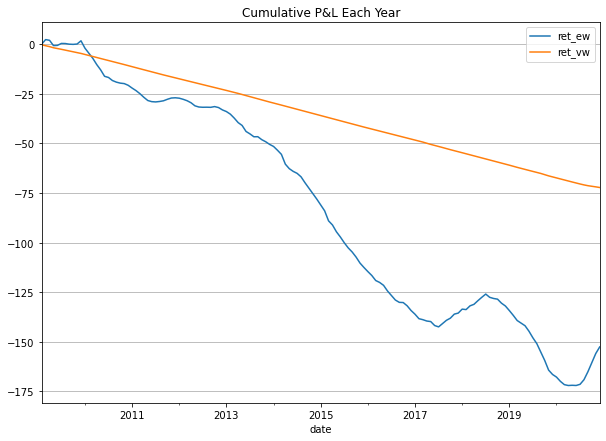

In [109]:
# Visualize profit & loss each year
plot_cum_ret(pnl.reset_index())

#### Replicate table 3 panel A

In [110]:
# Equally-weighted portfolio
df_add_title(PC_ranks_ew, 'Panel A for %s Equally-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.082400,0.051403,0.030997
Component_20~39,0.017894,0.014222,0.003671
Component_40~59,0.008421,0.001979,0.006442
Component_60~79,-0.000822,-0.000566,-0.000256
Component_80~99,-0.000250,-0.000798,0.000548


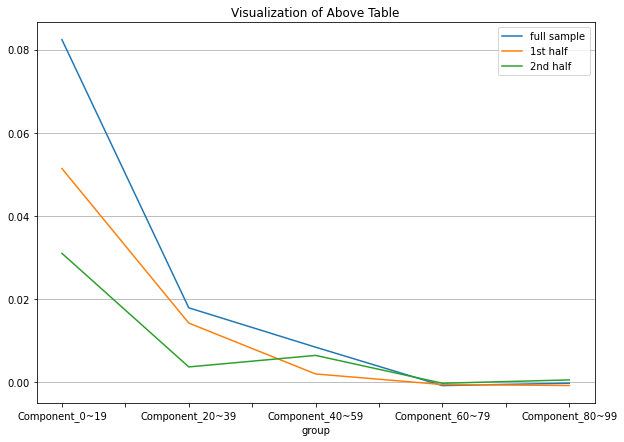

In [111]:
# Visualize above table
plot_PC_ret(PC_ranks_ew)

In [112]:
# Value-weighted portfolio
df_add_title(PC_ranks_vw, 'Panel A for %s Value-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.012851,0.010667,0.002184
Component_20~39,0.001419,0.000716,0.000702
Component_40~59,0.000338,0.000234,0.000104
Component_60~79,0.000096,0.000059,0.000036
Component_80~99,0.000031,0.000005,0.000026


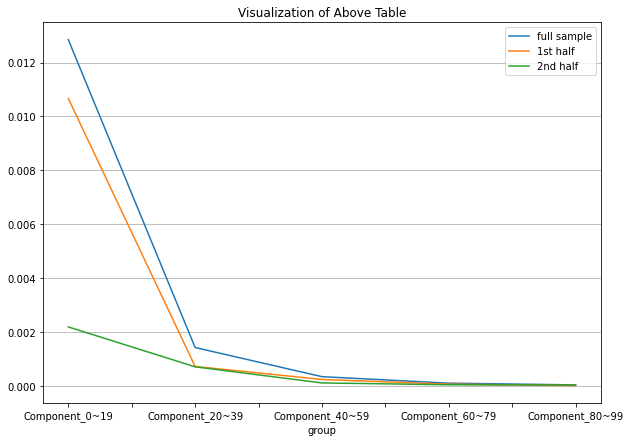

In [113]:
# Visualize above table
plot_PC_ret(PC_ranks_vw)

#### Replicate table 3 panel B

In [114]:
# Equally-weighted portfolio
df_add_title(panelB_ew, 'Panel B for %s Equally-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,-0.00079 (0.06432),-0.00011 (0.38165),-0.00007 (0.38497),-0.00001 (0.24683)
mkt_rf,-0.00812 (0.28769),-0.00238 (0.37280),-0.00059 (0.51336),0.00006 (0.59405)
smb,0.00171 (0.58964),0.00142 (0.45529),0.00082 (0.48998),-0.00049 (0.49355)
hml,0.00347 (0.50597),0.00088 (0.47592),-0.00116 (0.40672),0.00003 (0.61210)
rmw,-0.00579 (0.42115),-0.00358 (0.41611),0.00003 (0.52270),-0.00048 (0.56163)
cma,0.00368 (0.54372),0.00067 (0.53617),0.00013 (0.46850),0.00003 (0.61710)
alpha_1st,0.20036 (0.00843),0.04138 (0.25757),0.01198 (0.39039),0.00194 (0.54113)
alpha_2nd,0.30236 (0.00634),0.09518 (0.07434),0.01321 (0.50535),0.00411 (0.47635)
Component_0_19,0.04308 (0.06008),0.01076 (0.34831),0.00251 (0.58613),0.00063 (0.68195)
adj. R sq,0.12705,0.03407,0.00303,-0.02022


In [115]:
# Value-weighted portfolio
df_add_title(panelB_vw, 'Panel B for %s Value-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,0.00000 (0.49861),0.00000 (0.44793),0.00000 (0.47481),0.00000 (0.17464)
mkt_rf,-0.00002 (0.56569),0.00001 (0.51366),0.00001 (0.49767),-0.00000 (0.53724)
smb,0.00001 (0.59604),-0.00007 (0.47281),0.00000 (0.62636),-0.00000 (0.48628)
hml,0.00020 (0.38851),0.00007 (0.30318),0.00000 (0.50320),0.00001 (0.49473)
rmw,0.00005 (0.39791),-0.00003 (0.54051),0.00002 (0.39446),-0.00001 (0.46838)
cma,-0.00030 (0.43819),0.00006 (0.44802),-0.00000 (0.54765),-0.00001 (0.48769)
alpha_1st,0.17618 (0.02598),0.02795 (0.30030),0.00623 (0.49022),0.00119 (0.62147)
alpha_2nd,0.13047 (0.13337),0.03583 (0.25688),0.00507 (0.52723),0.00161 (0.55927)
Component_0_19,0.01228 (0.25170),0.00250 (0.52978),0.00050 (0.72639),0.00008 (0.83702)
adj. R sq,0.08446,0.01594,-0.01317,-0.01679


#### Replicate table 3 panel C

In [116]:
df_add_title(panelC_ew, 'Panel C for %s Equally-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00415 (0.00000),-0.00396 (0.00000),-0.00391 (0.00000),-0.00393 (0.00000),-0.00391 (0.00000)
mkt_rf,-0.00279 (0.58652),0.00008 (0.62096),-0.00099 (0.62886),-0.00094 (0.61689),-0.00121 (0.61805)
smb,0.00126 (0.59910),-0.00046 (0.57450),-0.00146 (0.58987),-0.00079 (0.59633),-0.00094 (0.59133)
hml,0.00762 (0.60259),0.00185 (0.61115),0.00183 (0.63738),0.00202 (0.62985),0.00376 (0.62992)
rmw,-0.00751 (0.49682),-0.00721 (0.47307),-0.00966 (0.48338),-0.00905 (0.48701),-0.00811 (0.47626)
cma,-0.02927 (0.33399),-0.02177 (0.44579),-0.02096 (0.45593),-0.02134 (0.44263),-0.02366 (0.41917)
alpha_1st,1.06807 (0.00000),1.07145 (0.00000),1.07109 (0.00000),1.07106 (0.00000),1.07245 (0.00000)
alpha_2nd,1.30395 (0.00000),1.33063 (0.00000),1.33409 (0.00000),1.33662 (0.00000),1.34026 (0.00000)
Component_20_39,0.54683 (0.00145),nan,nan,nan,0.12960 (0.40889)
Component_40_59,nan,0.53137 (0.17409),nan,nan,0.12552 (0.44594)


In [117]:
df_add_title(panelC_vw, 'Panel C for %s Value-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00007 (0.00000),-0.00007 (0.00001),-0.00007 (0.00001),-0.00007 (0.00003),-0.00006 (0.00007)
mkt_rf,0.00034 (0.30818),0.00034 (0.29246),0.00033 (0.30862),0.00033 (0.30557),0.00034 (0.29744)
smb,-0.00040 (0.45707),-0.00042 (0.39129),-0.00043 (0.37731),-0.00043 (0.37804),-0.00043 (0.40043)
hml,0.00110 (0.04255),0.00114 (0.03006),0.00116 (0.02678),0.00116 (0.02734),0.00115 (0.03109)
rmw,0.00004 (0.56327),0.00003 (0.53504),0.00002 (0.50142),0.00001 (0.51907),0.00002 (0.53860)
cma,-0.00054 (0.47201),-0.00050 (0.46812),-0.00054 (0.42455),-0.00054 (0.42661),-0.00052 (0.45936)
alpha_1st,1.03605 (0.00000),1.04114 (0.00000),1.04033 (0.00000),1.04001 (0.00000),1.04035 (0.00000)
alpha_2nd,1.09318 (0.00000),1.07718 (0.00000),1.07878 (0.00000),1.07955 (0.00000),1.09062 (0.00000)
Component_20_39,0.50581 (0.03769),nan,nan,nan,0.10843 (0.34794)
Component_40_59,nan,0.37433 (0.37114),nan,nan,-0.02683 (0.53949)


#### Sharpe ratio

In [118]:
# Evaluate Sharpe ratio.
df_add_title(sharpe(pnl, ff5), 'Sharpe Ratio of Such Strategy in %s' % region)

,Annualized Sharpe Ratio
ret_ew,-2.099627
ret_vw,-35.228296


# Going the extra mile: introducing moving average to trading data. Assume no transaction cost.

**Prepare tradeable data by creating lags & 30-day moving average**

In [119]:
# Create lag for data since we cannot trade based on latest information.
days = 30
tradeable_data = {region: add_lag_mv(data_, days) for region, data_ in data.items()}

### (a) China

In [120]:
region = 'China'

In [121]:
%%time
# calculate PnL each year, non-cumulative version
pnl, PC_ranks_ew, PC_ranks_vw, panelB_ew, panelB_vw, panelC_ew, panelC_vw = compute_pnl(tradeable_data[region.lower()], ff5)

Wall time: 23min 53s


#### Simple, non-compounding accumulative P&L 

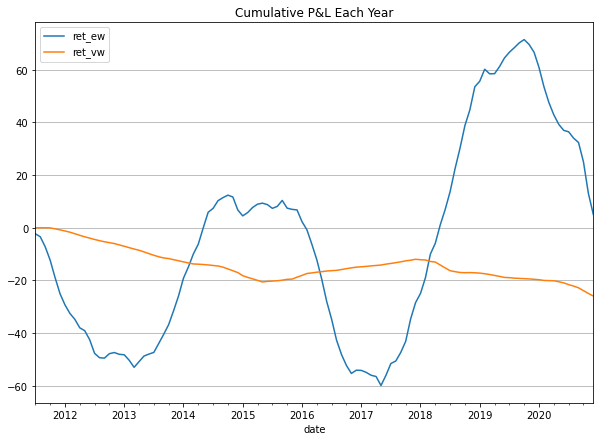

In [122]:
# Visualize profit & loss each year
plot_cum_ret(pnl.reset_index())

#### Replicate table 3 panel A

In [123]:
# Equally-weighted portfolio
df_add_title(PC_ranks_ew, 'Panel A for %s Equally-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.153787,0.093687,0.060100
Component_20~39,-0.011112,-0.005373,-0.005739
Component_40~59,-0.011711,-0.005736,-0.005975
Component_60~79,0.000714,0.000355,0.000359
Component_80~99,-0.000391,-0.000198,-0.000193


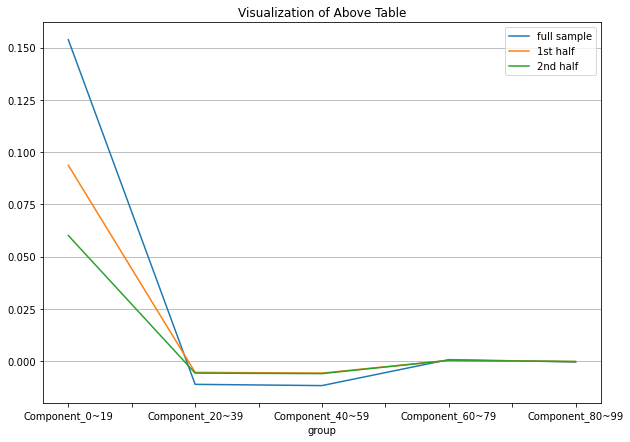

In [124]:
# Visualize above table
plot_PC_ret(PC_ranks_ew)

In [125]:
# Value-weighted portfolio
df_add_title(PC_ranks_vw, 'Panel A for %s Value-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.030466,0.006331,0.024135
Component_20~39,-0.000216,-0.000102,-0.000114
Component_40~59,-0.000193,-0.000098,-0.000095
Component_60~79,0.000157,0.000077,0.000080
Component_80~99,0.000044,0.000022,0.000022


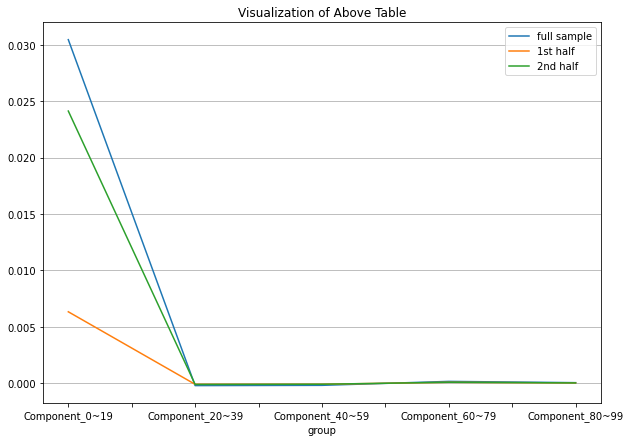

In [126]:
# Visualize above table
plot_PC_ret(PC_ranks_vw)

#### Replicate table 3 panel B

In [127]:
# Equally-weighted portfolio
df_add_title(panelB_ew, 'Panel B for %s Equally-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,-0.00017 (0.04550),-0.00012 (0.01953),0.00001 (0.02256),-0.00000 (0.00809)
mkt_rf,-0.00005 (0.50469),0.00000 (0.48601),-0.00003 (0.51500),-0.00001 (0.58339)
smb,0.00027 (0.52962),-0.00001 (0.46554),0.00007 (0.51741),0.00001 (0.57558)
hml,0.00007 (0.58875),0.00022 (0.48266),0.00001 (0.51515),-0.00002 (0.51457)
rmw,0.00014 (0.47567),0.00013 (0.48253),-0.00002 (0.49090),-0.00002 (0.49930)
cma,0.00018 (0.57827),-0.00011 (0.54629),-0.00002 (0.49524),0.00004 (0.46694)
alpha_1st,0.13740,0.22585 (0.40024),-0.00775,0.00816
alpha_2nd,0.14227,0.04918 (0.42904),0.00106,-0.00089
Component_0_19,0.03026 (0.31131),0.00474 (0.52117),0.00110 (0.65175),0.00030 (0.68869)
adj. R sq,0.02346,-0.00400,-0.00943,-0.02254


In [128]:
# Value-weighted portfolio
df_add_title(panelB_vw, 'Panel B for %s Value-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,-0.00000 (0.08338),-0.00000 (0.04352),0.00000 (0.02916),0.00000 (0.01378)
mkt_rf,-0.00002 (0.45123),-0.00000 (0.46449),0.00000 (0.55799),-0.00000 (0.53309)
smb,0.00001 (0.60845),-0.00000 (0.47758),0.00000 (0.56017),-0.00000 (0.58294)
hml,0.00001 (0.57406),0.00000 (0.51388),-0.00000 (0.44743),0.00000 (0.63819)
rmw,-0.00003 (0.51734),0.00001 (0.47915),-0.00000 (0.50723),-0.00000 (0.50997)
cma,0.00006 (0.42433),-0.00001 (0.53560),-0.00000 (0.48760),0.00000 (0.56769)
alpha_1st,0.09872 (0.41463),0.01218,0.13545,0.00210 (0.62415)
alpha_2nd,0.12260,-0.00072,0.00215,-0.00133
Component_0_19,0.00210 (0.67917),0.00009 (0.78091),0.00002 (0.81443),0.00001 (0.82369)
adj. R sq,-0.00426,-0.00700,-0.01950,-0.02683


#### Replicate table 3 panel C

In [129]:
df_add_title(panelC_ew, 'Panel C for %s Equally-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00126 (0.00688),-0.00134 (0.01550),-0.00136 (0.03761),-0.00135 (0.18278),-0.00135 (0.25261)
mkt_rf,0.00036 (0.45676),0.00015 (0.47378),0.00010 (0.48332),0.00015 (0.47058),0.00018 (0.47870)
smb,0.00067 (0.46944),0.00076 (0.48796),0.00094 (0.49863),0.00096 (0.49033),0.00092 (0.49855)
hml,-0.00249 (0.51866),-0.00246 (0.54571),-0.00269 (0.52985),-0.00272 (0.51595),-0.00260 (0.52583)
rmw,0.00072 (0.58493),0.00025 (0.60961),0.00036 (0.61249),0.00045 (0.59894),0.00051 (0.59865)
cma,0.00263 (0.55765),0.00241 (0.53321),0.00273 (0.54431),0.00283 (0.54707),0.00270 (0.54519)
alpha_1st,1.42245 (0.00000),1.40317 (0.00000),1.43660 (0.00000),1.43647 (0.00000),1.42672 (0.00000)
alpha_2nd,1.66186 (0.00005),1.58220 (0.00000),1.63046 (0.00003),1.62424 (0.00005),1.62152 (0.00002)
Component_20_39,0.81060 (0.13045),nan,nan,nan,0.16133 (0.41534)
Component_40_59,nan,0.78569 (0.37785),nan,nan,0.12103 (0.57781)


In [130]:
df_add_title(panelC_vw, 'Panel C for %s Value-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00003 (0.02567),-0.00003 (0.09610),-0.00003 (0.10218),-0.00003 (0.23824),-0.00003 (0.29734)
mkt_rf,-0.00001 (0.62234),-0.00001 (0.63664),-0.00001 (0.65686),-0.00001 (0.66729),-0.00001 (0.64860)
smb,-0.00003 (0.50156),-0.00002 (0.50267),-0.00003 (0.49281),-0.00003 (0.48279),-0.00003 (0.49832)
hml,-0.00012 (0.33787),-0.00013 (0.32635),-0.00012 (0.31976),-0.00012 (0.33069),-0.00013 (0.33662)
rmw,-0.00001 (0.64695),-0.00000 (0.64138),-0.00000 (0.64206),-0.00000 (0.64620),-0.00001 (0.65275)
cma,0.00030 (0.42400),0.00030 (0.42005),0.00030 (0.42081),0.00030 (0.43859),0.00031 (0.44059)
alpha_1st,1.14491 (0.00000),1.14247 (0.00000),1.14774 (0.00000),1.14605 (0.00000),1.14488 (0.00000)
alpha_2nd,1.07592 (0.00000),1.07604 (0.00000),1.07767 (0.00000),1.07653 (0.00000),1.07646 (0.00000)
Component_20_39,0.94917 (0.02056),nan,nan,nan,0.25876 (0.17945)
Component_40_59,nan,0.98780 (0.17597),nan,nan,0.30637 (0.34706)


#### Sharpe ratio

In [131]:
# Evaluate Sharpe ratio.
df_add_title(sharpe(pnl, ff5), 'Sharpe Ratio of Such Strategy in %s' % region)

,Annualized Sharpe Ratio
ret_ew,0.033906
ret_vw,-1.957880


### (b) HK

In [132]:
region = 'HK'

In [133]:
%%time
# calculate PnL each year, non-cumulative version
pnl, PC_ranks_ew, PC_ranks_vw, panelB_ew, panelB_vw, panelC_ew, panelC_vw = compute_pnl(tradeable_data[region.lower()], ff5)

Wall time: 20min 57s


#### Simple, non-compounding accumulative P&L 

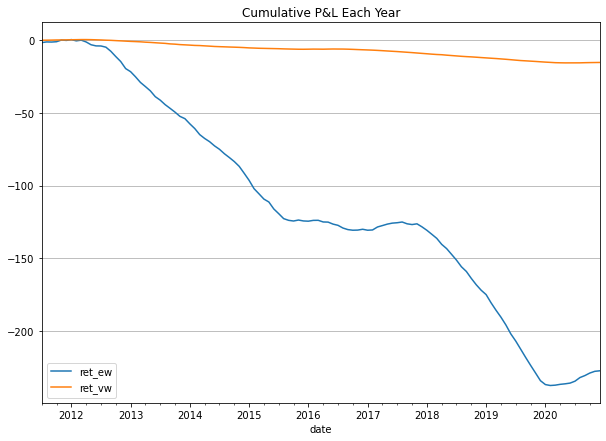

In [134]:
# Visualize profit & loss each year
plot_cum_ret(pnl.reset_index())

#### Replicate table 3 panel A

In [135]:
# Equally-weighted portfolio
df_add_title(PC_ranks_ew, 'Panel A for %s Equally-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.175304,-0.032813,0.208116
Component_20~39,-0.024418,-0.011803,-0.012615
Component_40~59,-0.009732,-0.004703,-0.005029
Component_60~79,-0.009071,-0.004478,-0.004593
Component_80~99,0.001942,0.000985,0.000957


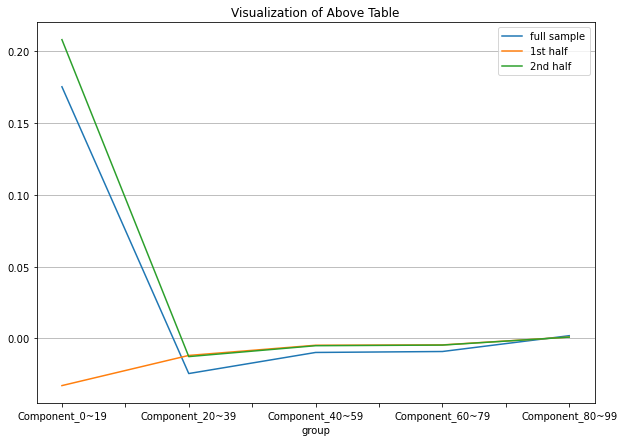

In [136]:
# Visualize above table
plot_PC_ret(PC_ranks_ew)

In [137]:
# Value-weighted portfolio
df_add_title(PC_ranks_vw, 'Panel A for %s Value-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.013481,-0.000433,0.013914
Component_20~39,-0.000017,-0.000001,-0.000016
Component_40~59,-0.000478,-0.000237,-0.000242
Component_60~79,-0.000159,-0.000078,-0.000081
Component_80~99,0.000151,0.000074,0.000076


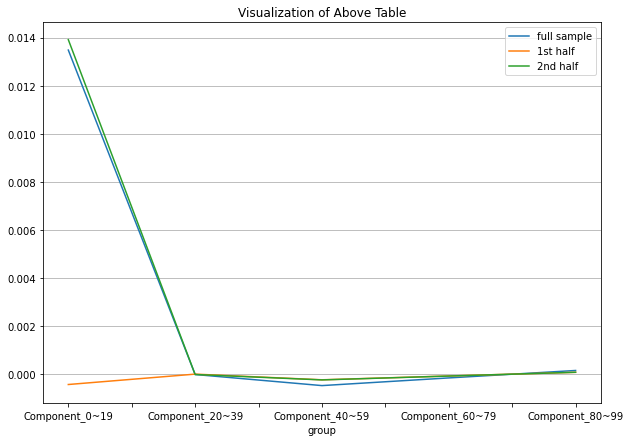

In [138]:
# Visualize above table
plot_PC_ret(PC_ranks_vw)

#### Replicate table 3 panel B

In [139]:
# Equally-weighted portfolio
df_add_title(panelB_ew, 'Panel B for %s Equally-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,-0.00033 (0.06206),-0.00011 (0.04580),-0.00009 (0.01178),0.00002 (0.00070)
mkt_rf,-0.00060 (0.50340),-0.00000 (0.48529),0.00002 (0.46599),0.00001 (0.51730)
smb,0.00122 (0.42559),0.00002 (0.60333),0.00003 (0.51686),-0.00002 (0.50659)
hml,-0.00097 (0.48101),-0.00018 (0.43333),-0.00002 (0.50229),0.00001 (0.53272)
rmw,-0.00009 (0.35532),-0.00000 (0.56152),0.00008 (0.57307),-0.00002 (0.40382)
cma,0.00005 (0.46827),-0.00004 (0.38555),0.00005 (0.53301),0.00002 (0.59999)
alpha_1st,0.12524 (0.14527),0.02386 (0.37978),0.00355 (0.63618),0.00175 (0.58008)
alpha_2nd,0.47311,0.01842,-0.07404,0.00711
Component_0_19,0.02112 (0.28821),0.00435 (0.47336),0.00058 (0.71167),0.00039 (0.65076)
adj. R sq,0.04786,-0.00251,-0.02145,-0.01688


In [140]:
# Value-weighted portfolio
df_add_title(panelB_vw, 'Panel B for %s Value-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,-0.00000 (0.07457),-0.00000 (0.02132),-0.00000 (0.02033),0.00000 (0.01207)
mkt_rf,0.00000 (0.54318),0.00000 (0.53197),-0.00000 (0.52616),0.00000 (0.58117)
smb,-0.00000 (0.54935),-0.00001 (0.46405),-0.00000 (0.51422),-0.00000 (0.55532)
hml,-0.00001 (0.55456),0.00001 (0.36524),0.00000 (0.58169),0.00000 (0.47470)
rmw,0.00002 (0.44367),-0.00000 (0.47640),0.00000 (0.43463),-0.00000 (0.53903)
cma,0.00000 (0.52241),-0.00001 (0.56151),-0.00000 (0.52087),0.00000 (0.50245)
alpha_1st,0.06159 (0.25154),0.01185 (0.56919),0.00104 (0.79135),0.00020 (0.80857)
alpha_2nd,0.11626,0.04526,0.00233,-0.00140
Component_0_19,0.00691 (0.39094),0.00130 (0.58881),0.00005 (0.80824),0.00002 (0.82426)
adj. R sq,0.01063,-0.00446,-0.02256,-0.02407


#### Replicate table 3 panel C

In [141]:
df_add_title(panelC_ew, 'Panel C for %s Equally-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00100 (0.00204),-0.00105 (0.00980),-0.00102 (0.03574),-0.00104 (0.14091),-0.00099 (0.18399)
mkt_rf,-0.00029 (0.68607),-0.00006 (0.70448),0.00001 (0.69739),-0.00006 (0.69843),-0.00015 (0.68407)
smb,-0.00056 (0.59567),-0.00099 (0.57122),-0.00100 (0.57847),-0.00100 (0.57397),-0.00097 (0.56947)
hml,-0.00027 (0.47321),-0.00056 (0.40942),-0.00058 (0.39494),-0.00066 (0.40728),-0.00045 (0.41192)
rmw,-0.00054 (0.50124),-0.00025 (0.52371),-0.00048 (0.49612),-0.00064 (0.49355),-0.00060 (0.50081)
cma,0.00215 (0.49083),0.00249 (0.46833),0.00220 (0.47330),0.00227 (0.48066),0.00225 (0.47836)
alpha_1st,1.25427 (0.00000),1.28865 (0.00000),1.28379 (0.00000),1.30255 (0.00000),1.28142 (0.00000)
alpha_2nd,1.23843 (0.00000),1.24971 (0.00000),1.24929 (0.00000),1.26459 (0.00000),1.25073 (0.00000)
Component_20_39,0.83327 (0.01098),nan,nan,nan,0.21610 (0.30725)
Component_40_59,nan,0.76649 (0.16832),nan,nan,0.16295 (0.61042)


In [142]:
df_add_title(panelC_vw, 'Panel C for %s Value-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00004 (0.00133),-0.00004 (0.01397),-0.00004 (0.03716),-0.00003 (0.15969),-0.00003 (0.20638)
mkt_rf,-0.00001 (0.65268),-0.00000 (0.65000),-0.00001 (0.65920),-0.00001 (0.65468),-0.00001 (0.65160)
smb,0.00005 (0.59118),0.00003 (0.59453),0.00004 (0.58690),0.00004 (0.59796),0.00004 (0.59691)
hml,-0.00008 (0.46584),-0.00008 (0.49162),-0.00009 (0.47661),-0.00009 (0.48241),-0.00009 (0.48469)
rmw,0.00012 (0.47303),0.00012 (0.49414),0.00012 (0.49930),0.00013 (0.48989),0.00012 (0.48771)
cma,-0.00001 (0.47684),-0.00002 (0.46920),-0.00002 (0.45050),-0.00001 (0.44938),-0.00001 (0.45948)
alpha_1st,1.30040 (0.00026),1.50715 (0.00209),1.32556 (0.00054),1.40666 (0.00094),1.34376 (0.00110)
alpha_2nd,1.15041 (0.00000),1.13854 (0.00000),1.14330 (0.00000),1.15168 (0.00000),1.14551 (0.00000)
Component_20_39,0.83115 (0.02338),nan,nan,nan,0.26569 (0.36252)
Component_40_59,nan,0.66157 (0.31452),nan,nan,0.04248 (0.59222)


#### Sharpe ratio

In [143]:
# Evaluate Sharpe ratio.
df_add_title(sharpe(pnl, ff5), 'Sharpe Ratio of Such Strategy in %s' % region)

,Annualized Sharpe Ratio
ret_ew,-3.230926
ret_vw,-4.223594


### (c) US

In [144]:
region = 'US'

In [145]:
%%time
# calculate PnL each year, non-cumulative version
pnl, PC_ranks_ew, PC_ranks_vw, panelB_ew, panelB_vw, panelC_ew, panelC_vw = compute_pnl(tradeable_data[region.lower()], ff5)

Wall time: 20min 2s


#### Simple, non-compounding accumulative P&L 

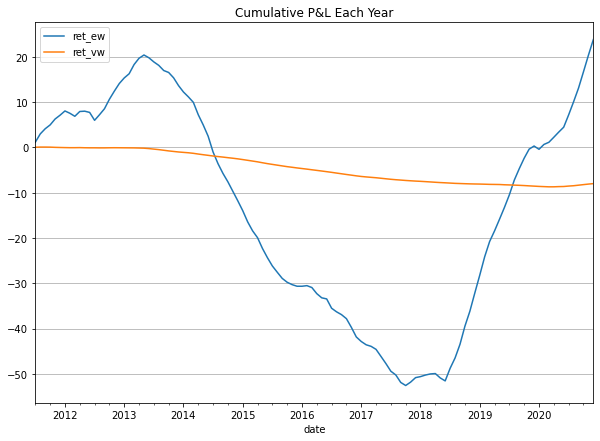

In [146]:
# Visualize profit & loss each year
plot_cum_ret(pnl.reset_index())

#### Replicate table 3 panel A

In [147]:
# Equally-weighted portfolio
df_add_title(PC_ranks_ew, 'Panel A for %s Equally-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.010242,0.057821,-0.047579
Component_20~39,0.006729,0.003205,0.003524
Component_40~59,0.006318,0.003107,0.003212
Component_60~79,-0.000350,-0.000184,-0.000166
Component_80~99,0.002794,0.001376,0.001418


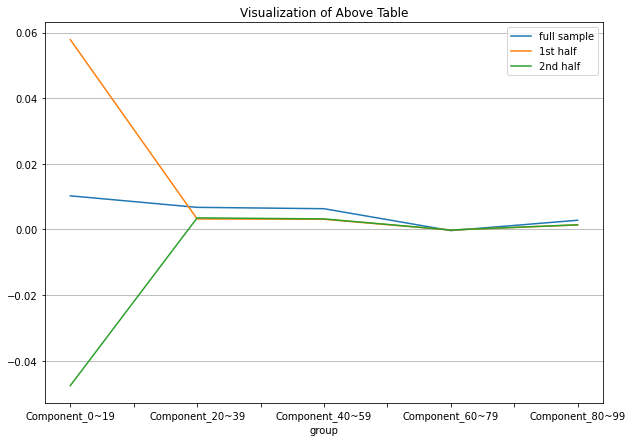

In [148]:
# Visualize above table
plot_PC_ret(PC_ranks_ew)

In [149]:
# Value-weighted portfolio
df_add_title(PC_ranks_vw, 'Panel A for %s Value-weighted Portfolios' % region)

,full sample,1st half,2nd half
group,,,
Component_0~19,0.002942,0.001738,0.001204
Component_20~39,0.000170,0.000070,0.000100
Component_40~59,-0.000065,-0.000031,-0.000034
Component_60~79,-0.000056,-0.000028,-0.000028
Component_80~99,-0.000002,-0.000001,-0.000001


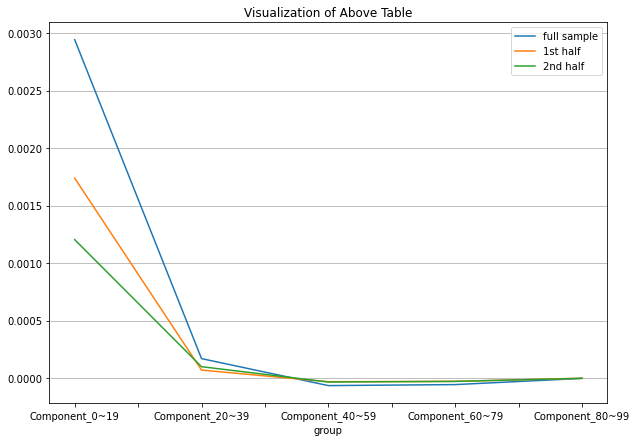

In [150]:
# Visualize above table
plot_PC_ret(PC_ranks_vw)

#### Replicate table 3 panel B

In [151]:
# Equally-weighted portfolio
df_add_title(panelB_ew, 'Panel B for %s Equally-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,0.00003 (0.06173),0.00006 (0.03631),-0.00000 (0.00635),0.00003 (0.00119)
mkt_rf,0.00020 (0.43788),0.00000 (0.53180),0.00002 (0.54179),-0.00000 (0.49738)
smb,-0.00003 (0.54616),-0.00001 (0.60582),-0.00001 (0.56880),0.00001 (0.54617)
hml,-0.00025 (0.42388),0.00002 (0.45815),0.00004 (0.48897),-0.00000 (0.52351)
rmw,-0.00017 (0.37852),-0.00004 (0.54378),0.00003 (0.48759),0.00001 (0.44477)
cma,-0.00037 (0.51592),0.00004 (0.48077),0.00000 (0.56717),0.00001 (0.53927)
alpha_1st,0.05030 (0.27374),0.00658 (0.50969),0.00157 (0.64719),0.00009 (0.73606)
alpha_2nd,0.03387 (0.21244),0.00480 (0.53518),0.00063 (0.72543),0.00006 (0.76942)
Component_0_19,0.01175 (0.33160),0.00171 (0.60445),0.00031 (0.73282),0.00002 (0.76434)
adj. R sq,0.02507,-0.02074,-0.01890,-0.02406


In [152]:
# Value-weighted portfolio
df_add_title(panelB_vw, 'Panel B for %s Value-weighted Portfolios' % region)

,Component_20~39,Component_40~59,Component_60~79,Component_80~99
Intercept,0.00000 (0.02307),-0.00000 (0.03872),-0.00000 (0.00675),-0.00000 (0.00036)
mkt_rf,-0.00001 (0.38601),0.00000 (0.47601),-0.00000 (0.43010),0.00000 (0.49402)
smb,0.00001 (0.43739),-0.00000 (0.52430),0.00000 (0.47762),-0.00000 (0.49267)
hml,-0.00001 (0.55121),0.00000 (0.51918),0.00000 (0.38689),0.00000 (0.54315)
rmw,0.00000 (0.47788),0.00000 (0.42167),-0.00000 (0.55462),-0.00000 (0.53476)
cma,0.00000 (0.47874),-0.00000 (0.43969),0.00000 (0.60333),0.00000 (0.48230)
alpha_1st,0.09093 (0.24006),0.05213 (0.61369),0.00010 (0.74996),0.00006 (0.70088)
alpha_2nd,0.02967 (0.29760),0.00364 (0.58618),0.00055 (0.70264),0.00002 (0.79121)
Component_0_19,0.00446 (0.46513),0.00048 (0.74392),0.00008 (0.82987),-0.00000 (0.88638)
adj. R sq,0.01741,-0.01327,-0.01204,-0.01881


#### Replicate table 3 panel C

In [153]:
df_add_title(panelC_ew, 'Panel C for %s Equally-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00104 (0.00183),-0.00110 (0.00616),-0.00104 (0.02257),-0.00112 (0.12436),-0.00110 (0.18401)
mkt_rf,-0.00185 (0.31174),-0.00184 (0.29646),-0.00184 (0.30264),-0.00183 (0.30262),-0.00188 (0.29276)
smb,-0.00206 (0.41155),-0.00225 (0.38841),-0.00210 (0.38908),-0.00213 (0.39477),-0.00209 (0.40000)
hml,0.00139 (0.52762),0.00116 (0.51178),0.00116 (0.51609),0.00123 (0.51456),0.00132 (0.52125)
rmw,0.00239 (0.59681),0.00231 (0.59451),0.00234 (0.59300),0.00245 (0.57943),0.00262 (0.57757)
cma,-0.00106 (0.60155),-0.00191 (0.58124),-0.00190 (0.58867),-0.00192 (0.58991),-0.00162 (0.60641)
alpha_1st,1.22723 (0.00000),1.22894 (0.00000),1.21976 (0.00000),1.22389 (0.00000),1.22593 (0.00000)
alpha_2nd,2.15155,1.90714 (0.00109),1.93106 (0.00163),1.91105 (0.00034),1.97821 (0.00176)
Component_20_39,0.59116 (0.30287),nan,nan,nan,0.14524 (0.58545)
Component_40_59,nan,0.79839 (0.50121),nan,nan,0.33936 (0.61764)


In [154]:
df_add_title(panelC_vw, 'Panel C for %s Value-weighted Portfolios' % region)

,0,1,2,3,4
Intercept,-0.00002 (0.00885),-0.00002 (0.02455),-0.00002 (0.05873),-0.00002 (0.15136),-0.00002 (0.26126)
mkt_rf,0.00000 (0.46720),0.00000 (0.48841),0.00000 (0.50542),0.00000 (0.49930),0.00000 (0.49780)
smb,0.00004 (0.49743),0.00004 (0.43518),0.00004 (0.43904),0.00004 (0.44421),0.00004 (0.45181)
hml,-0.00007 (0.34055),-0.00006 (0.35501),-0.00006 (0.34983),-0.00006 (0.34759),-0.00006 (0.35178)
rmw,0.00004 (0.66725),0.00005 (0.63130),0.00005 (0.62644),0.00005 (0.62630),0.00005 (0.63551)
cma,-0.00002 (0.24308),-0.00003 (0.24563),-0.00002 (0.24847),-0.00002 (0.24660),-0.00003 (0.24803)
alpha_1st,1.07582 (0.00000),1.07445 (0.00000),1.07415 (0.00000),1.07491 (0.00000),1.07494 (0.00000)
alpha_2nd,1.43548 (0.00000),1.38707 (0.00000),1.38678 (0.00000),1.39533 (0.00000),1.40321 (0.00000)
Component_20_39,0.59357 (0.22173),nan,nan,nan,0.04073 (0.58127)
Component_40_59,nan,0.71019 (0.57581),nan,nan,0.25809 (0.65370)


#### Sharpe ratio

In [155]:
# Evaluate Sharpe ratio.
df_add_title(sharpe(pnl, ff5), 'Sharpe Ratio of Such Strategy in %s' % region)

,Annualized Sharpe Ratio
ret_ew,0.384083
ret_vw,-3.358858
